In [8]:
# -*- coding: utf-8 -*-
"""Final_V1_Mixed_Signals.ipynb"""

import numpy as np
import matplotlib.pyplot as plt
import io
import re  # Import Regular Expressions to clean the "junk" data
from google.colab import files
import pandas as pd

# ==========================================
# 1. PARAMETERS
# ==========================================
FS = 100                 # Sampling Frequency (Hz)
CUTOFF_SAMPLE = 15000    # Cut off the signal here to remove end-noise

# Filepath setup
filepath = "/content/GodaMárton_from_25_09_30_to_25_11_18.csv"

# Optional: verify file load
try:
    data = pd.read_csv(filepath)
    print("File found via Pandas (verification only).")
except Exception as e:
    print(f"Warning: File not found at {filepath}. Please upload it.")

File found via Pandas (verification only).


In [9]:
# ==========================================
# PARSE THE MESSY CSV (using file path)
# ==========================================
parsed_data = []
current_name = None
current_hex = ""

# Read file content from path
with open(filepath, "r", encoding="utf-8", errors="ignore") as f:
    file_content = f.read().splitlines()

for line in file_content:
    line = line.strip()
    if not line:
        continue

    # If line contains '0x', it is a NEW record
    if '0x' in line:
        # Save the PREVIOUS record
        if current_name is not None:
            parsed_data.append({'Name': current_name, 'Hex': current_hex})

        # Start NEW record
        parts = line.split(',')
        current_name = parts[0].strip()

        # Extract Hex
        hex_split = line.split('0x')
        if len(hex_split) > 1:
            current_hex = hex_split[1].strip()
        else:
            current_hex = ""
    else:
        # Continuation line
        current_hex += line

# Save the LAST entry
if current_name is not None:
    parsed_data.append({'Name': current_name, 'Hex': current_hex})

print(f"Successfully parsed {len(parsed_data)} records. Starting conversion...")

Successfully parsed 41 records. Starting conversion...


In [10]:
# ==========================================
# 3. CONVERT & CLEAN
# ==========================================
processed_records = []

for record in parsed_data:
    raw_hex = record['Hex']

    # Regex to keep valid hex
    clean_hex = re.sub(r'[^0-9A-Fa-f]', '', raw_hex)

    # Ensure even length
    if len(clean_hex) % 2 != 0:
        clean_hex = clean_hex[:-1]

    try:
        data_bytes = bytes.fromhex(clean_hex)
        signal = np.array(list(data_bytes), dtype=float)

        # Apply basic artifact smoothing (Professor's logic)
        peak_indices = np.where(signal > 150)[0] # Adjusted threshold slightly up
        for idx in peak_indices:
            if idx > 0 and idx < len(signal) - 1:
                signal[idx] = (signal[idx - 1] + signal[idx + 1]) / 2
            else:
                signal[idx] = 0

        processed_records.append({'Name': record['Name'], 'Signal': signal})

    except Exception as e:
        print(f"Error for {record['Name']}: {e}")

Organized data into 13 Subject Groups.

Generating Plots...


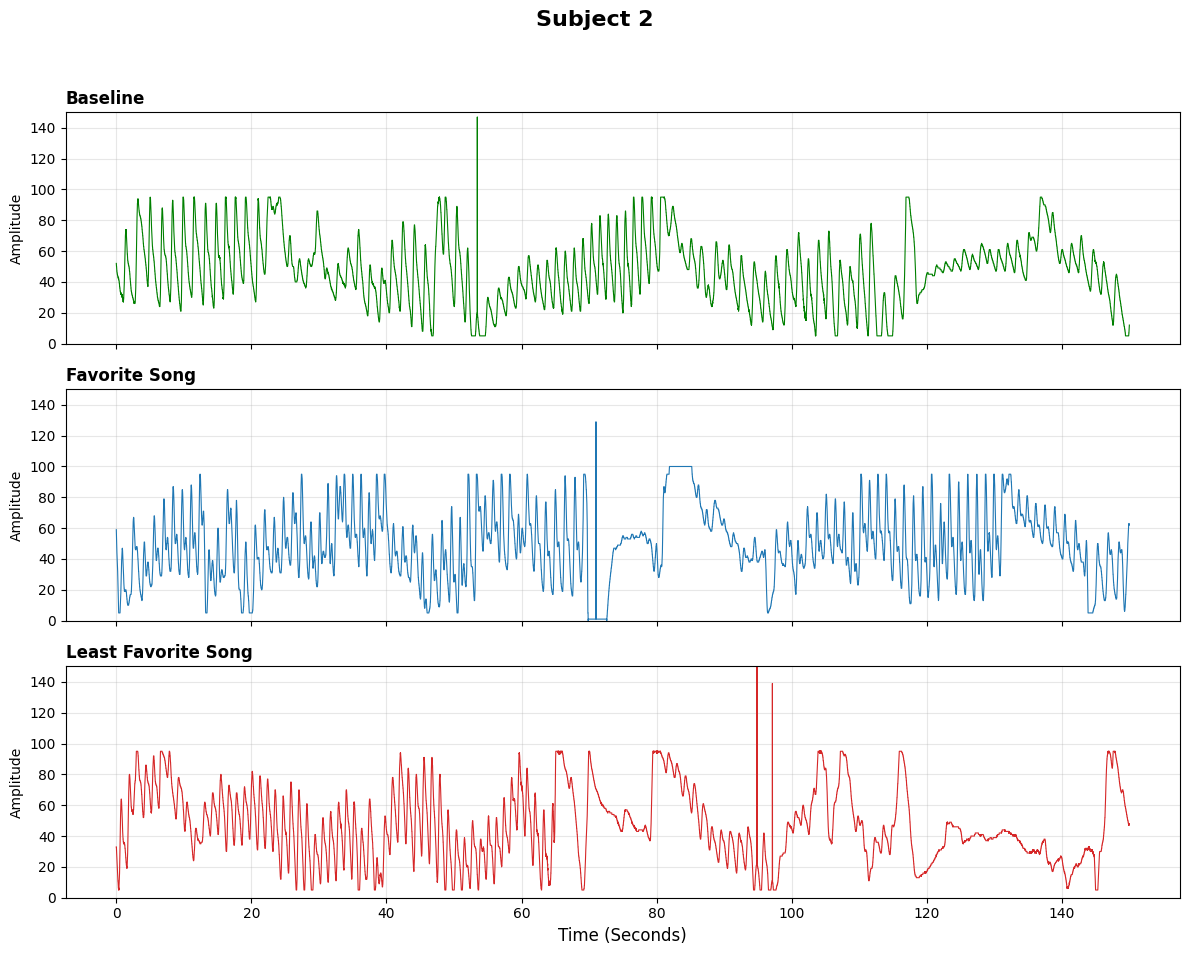

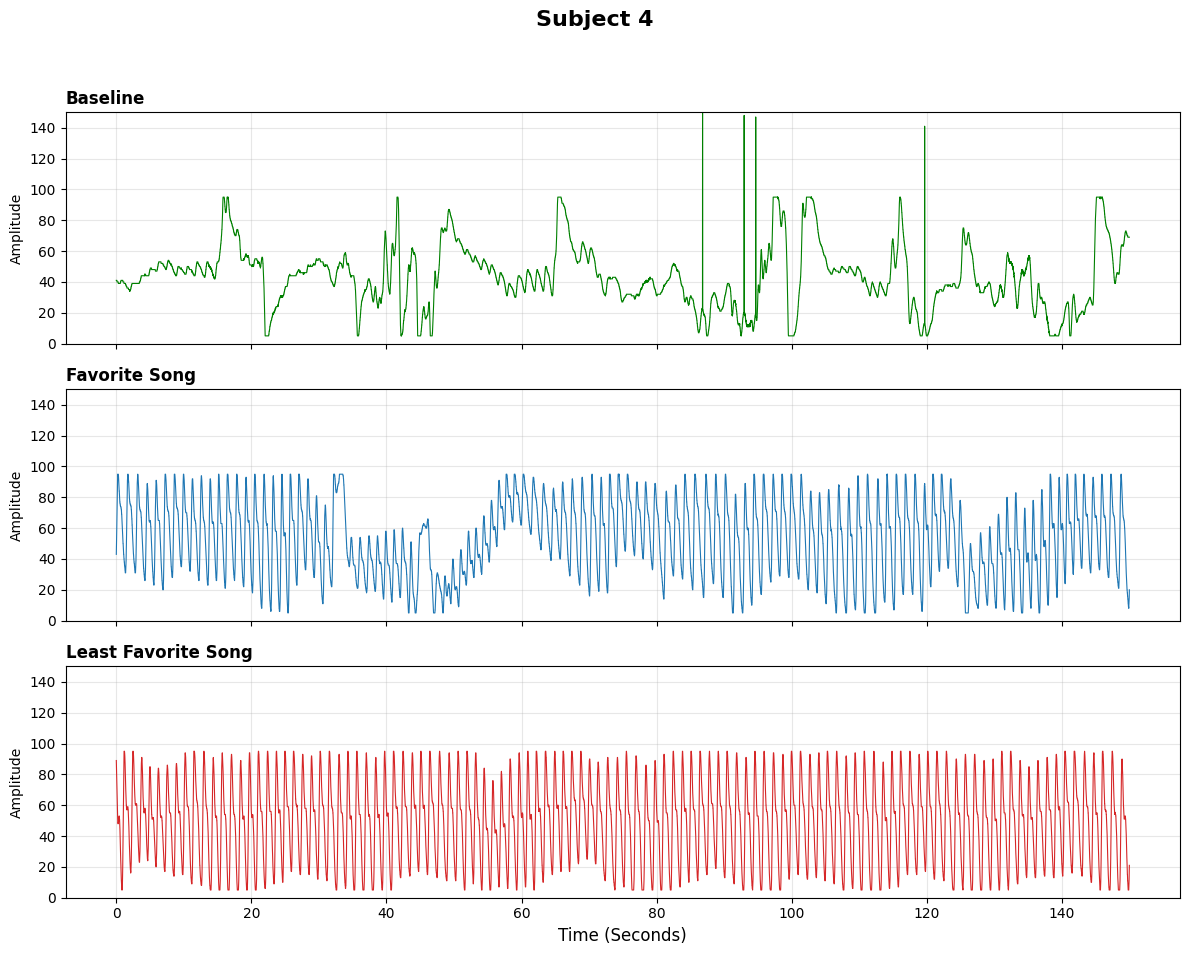

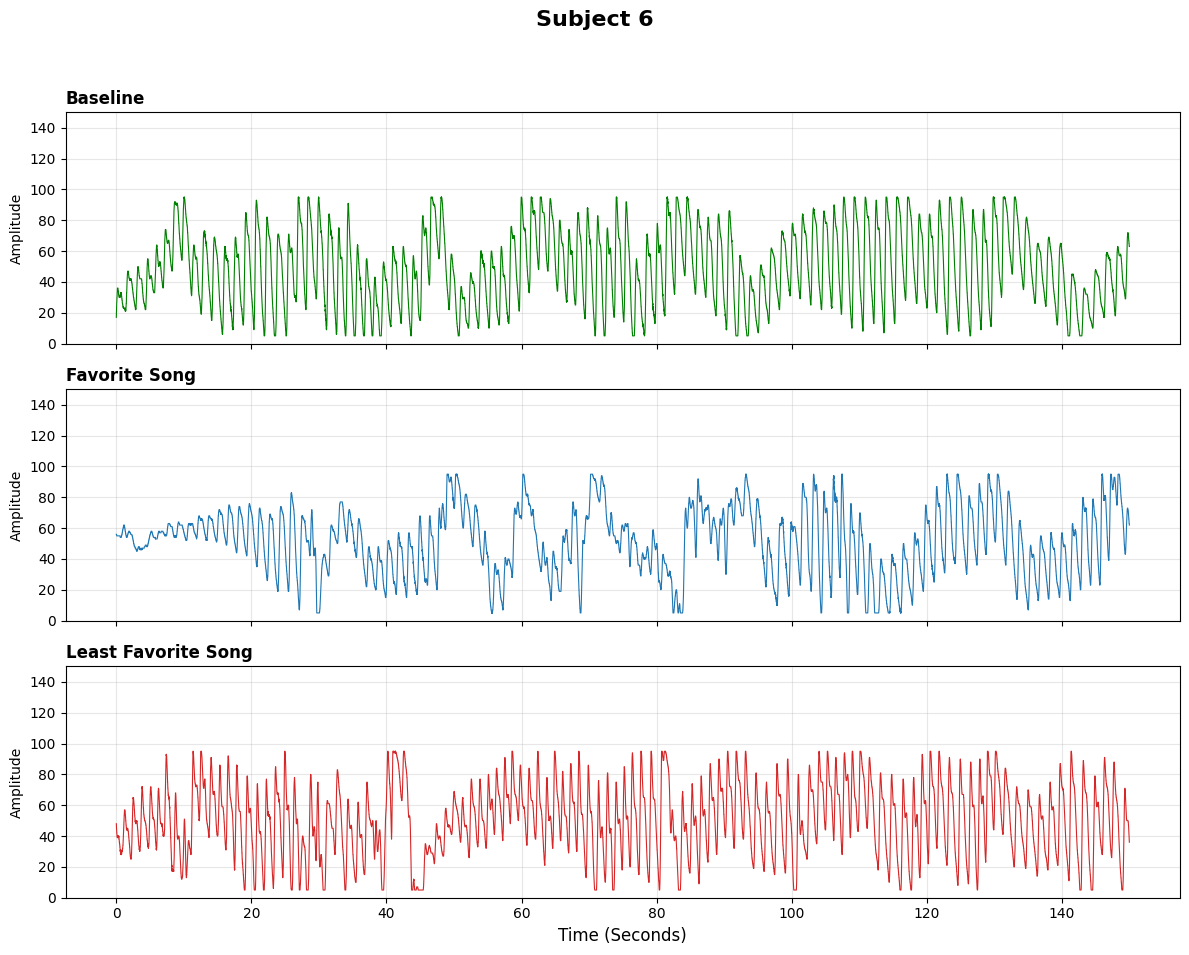

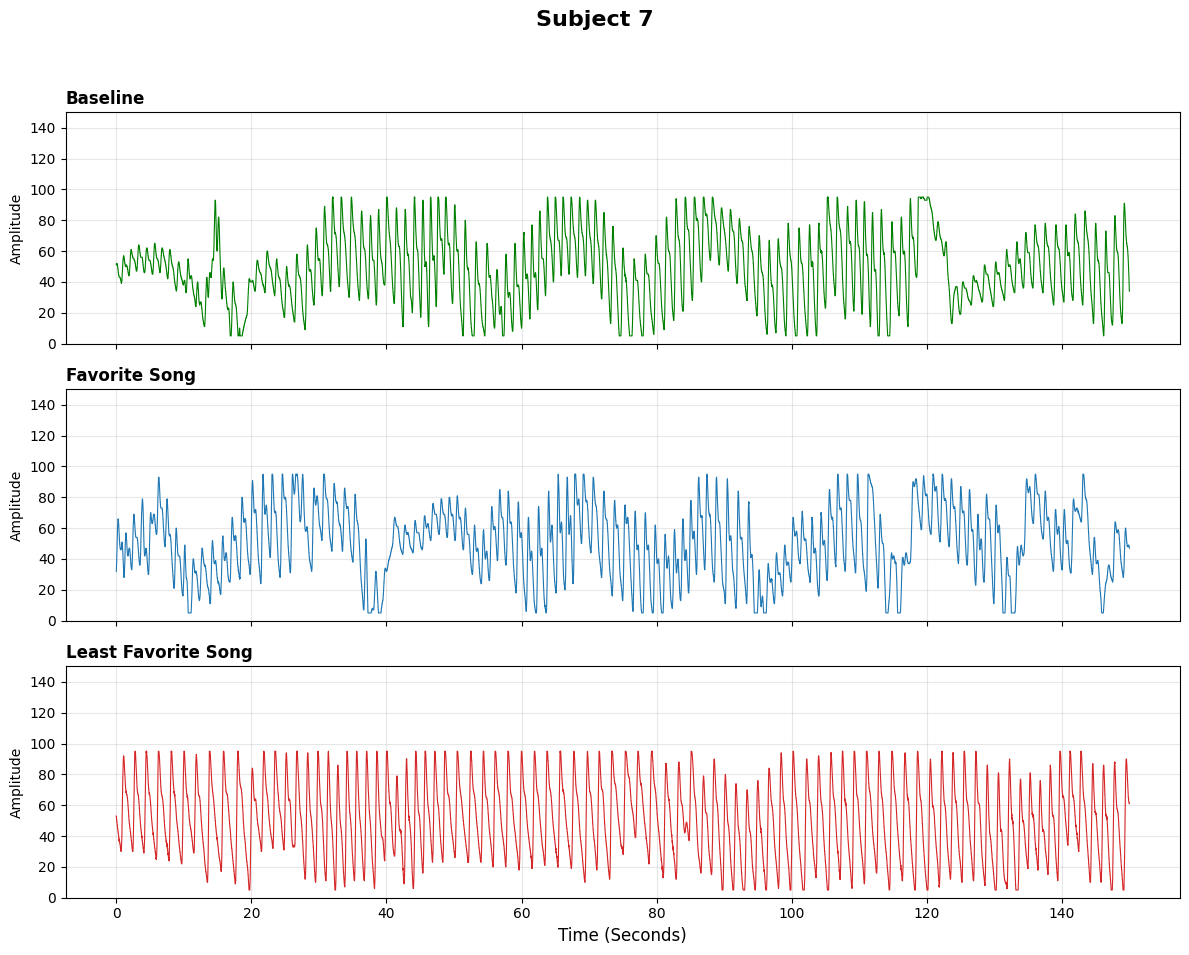

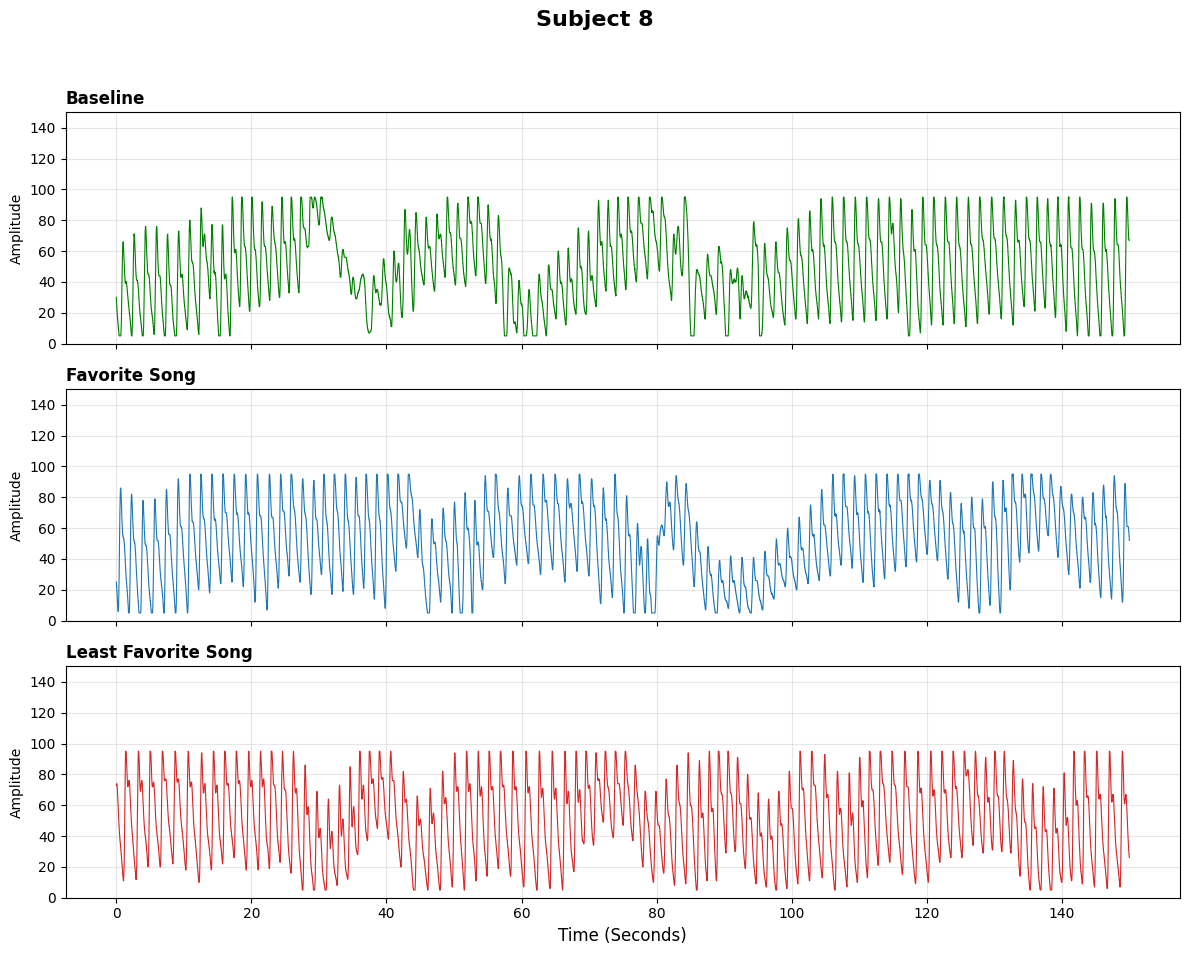

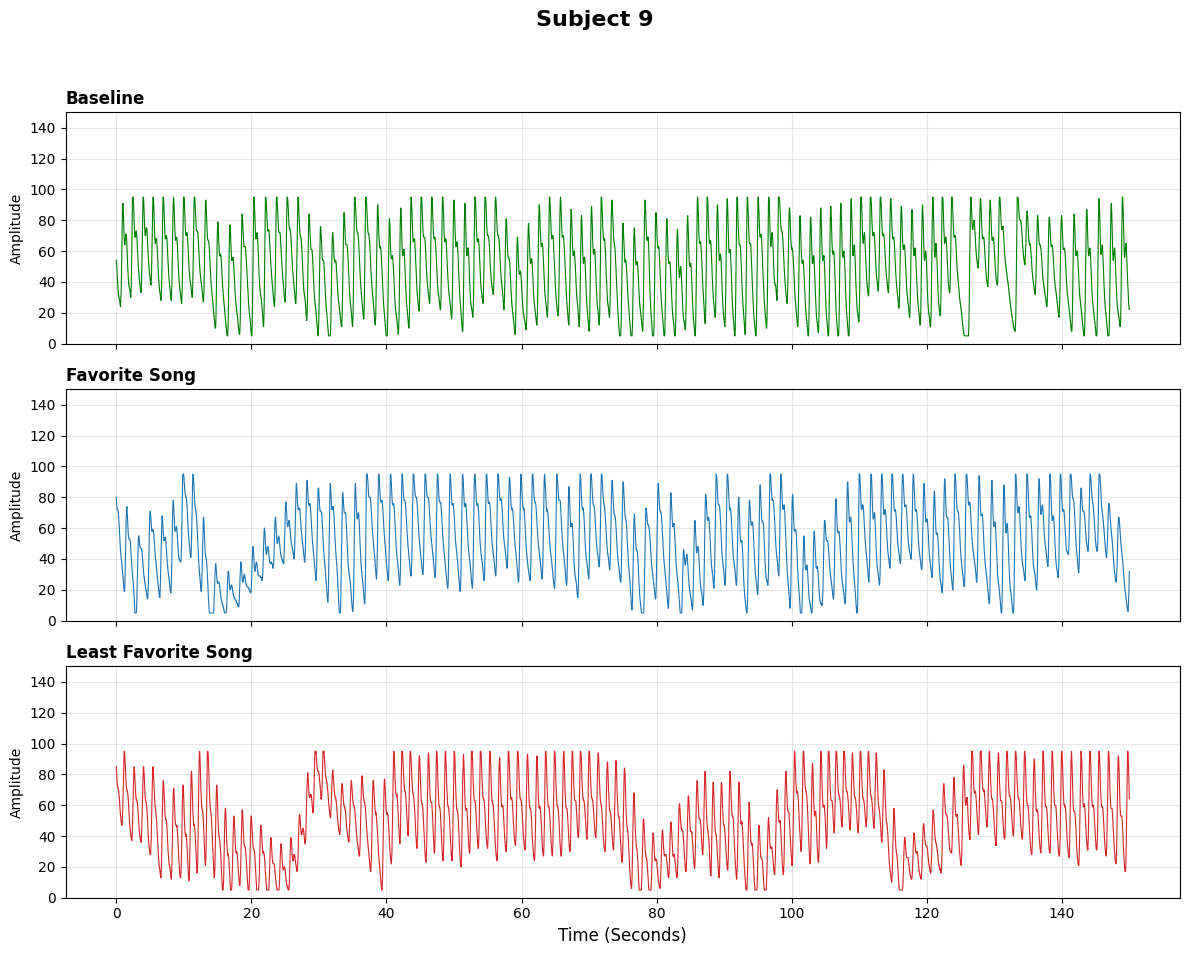

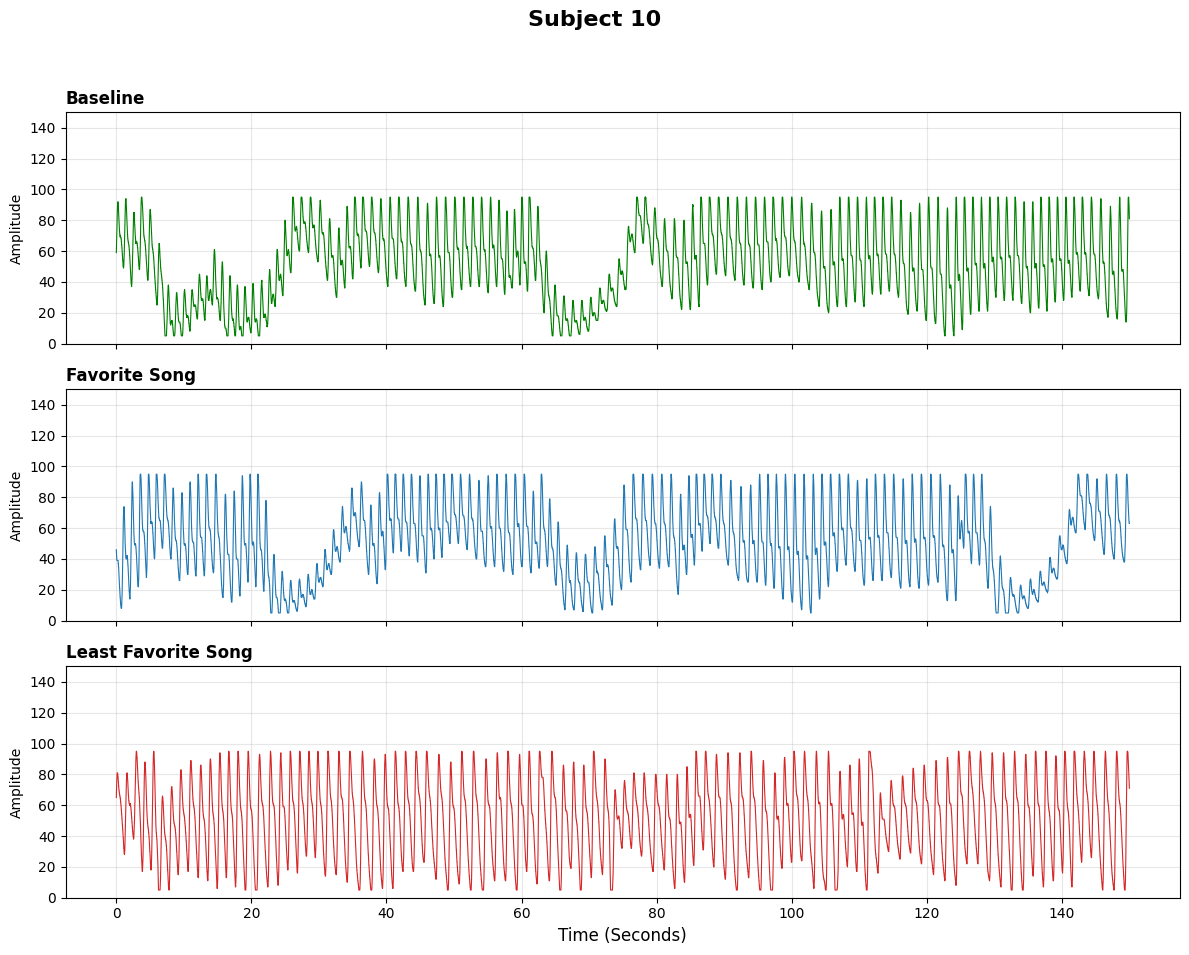

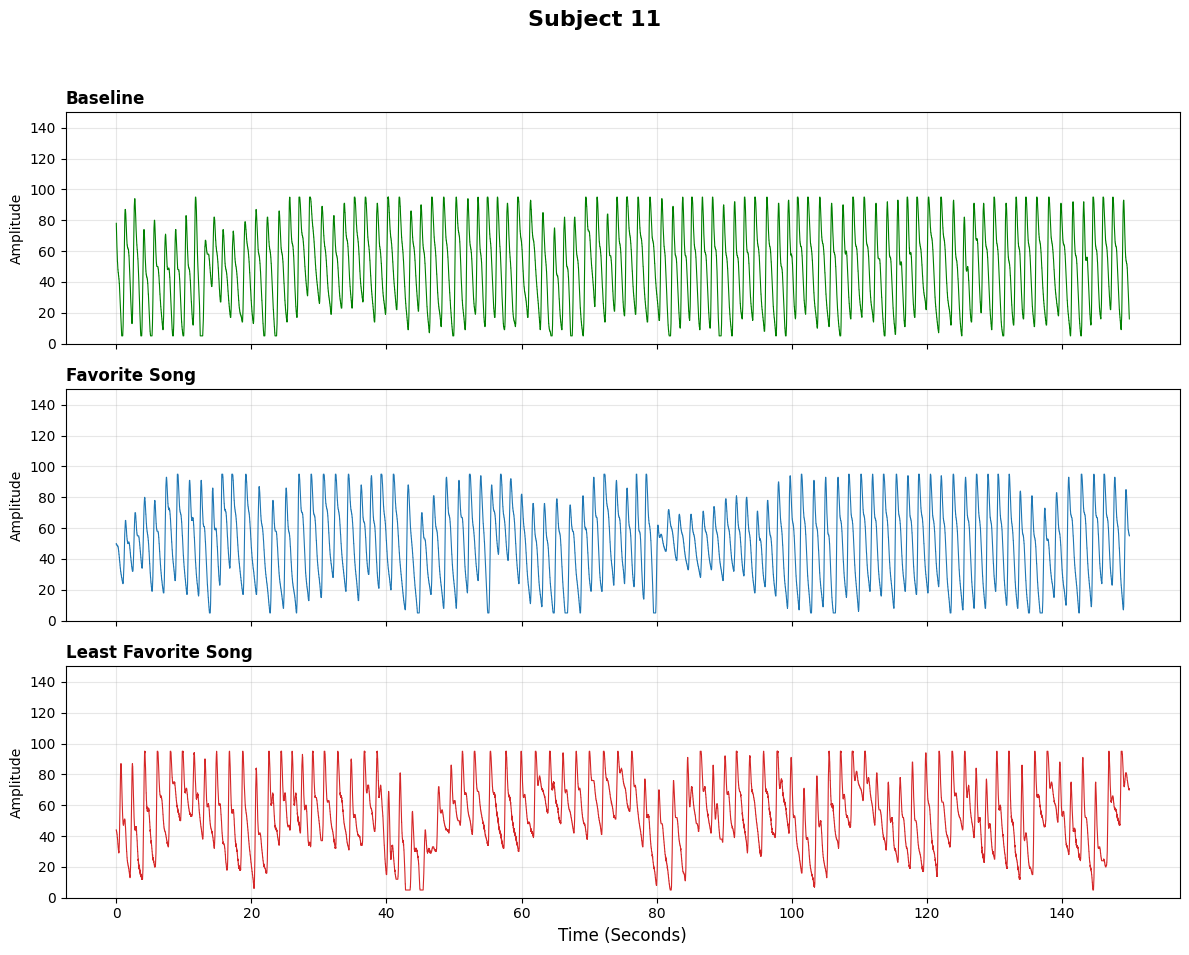

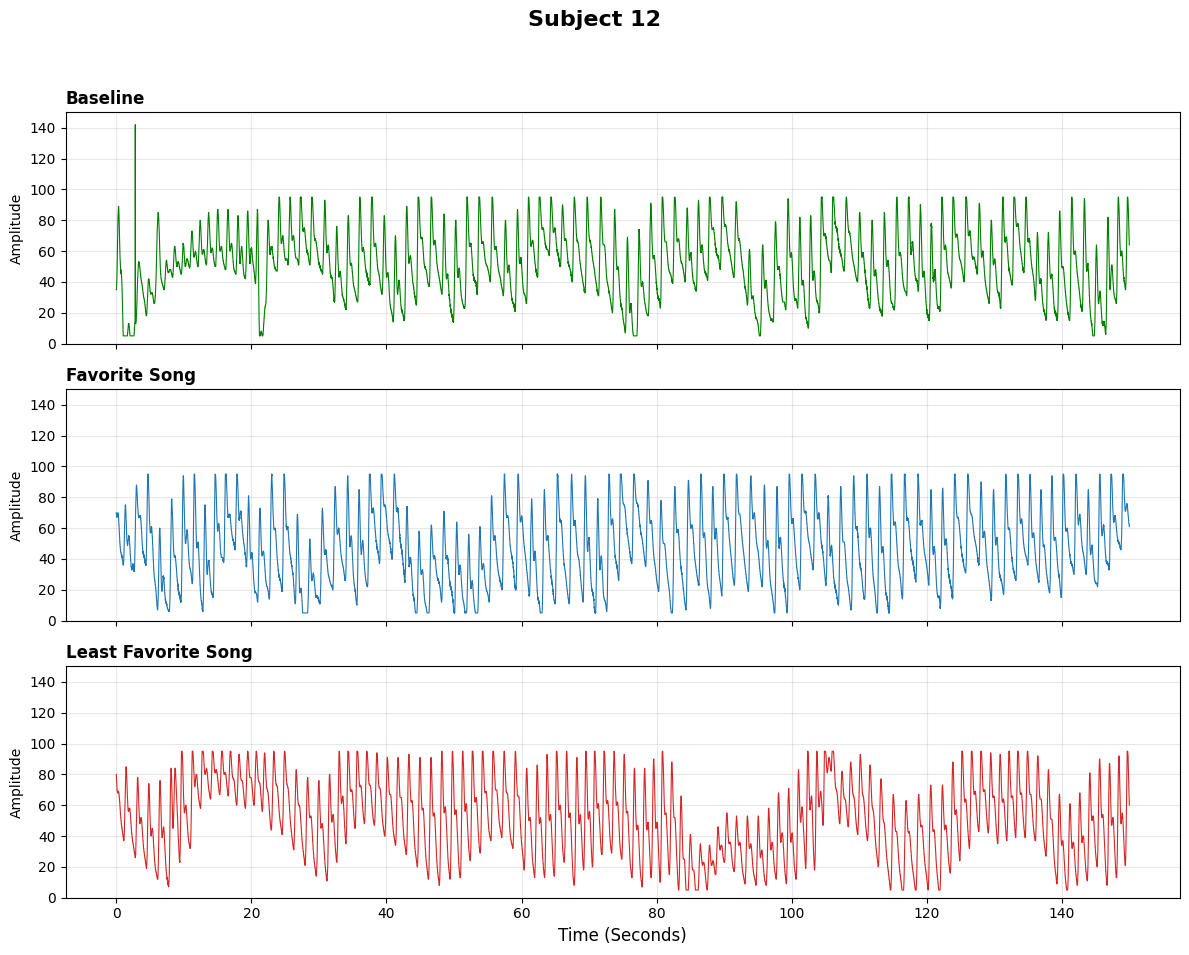

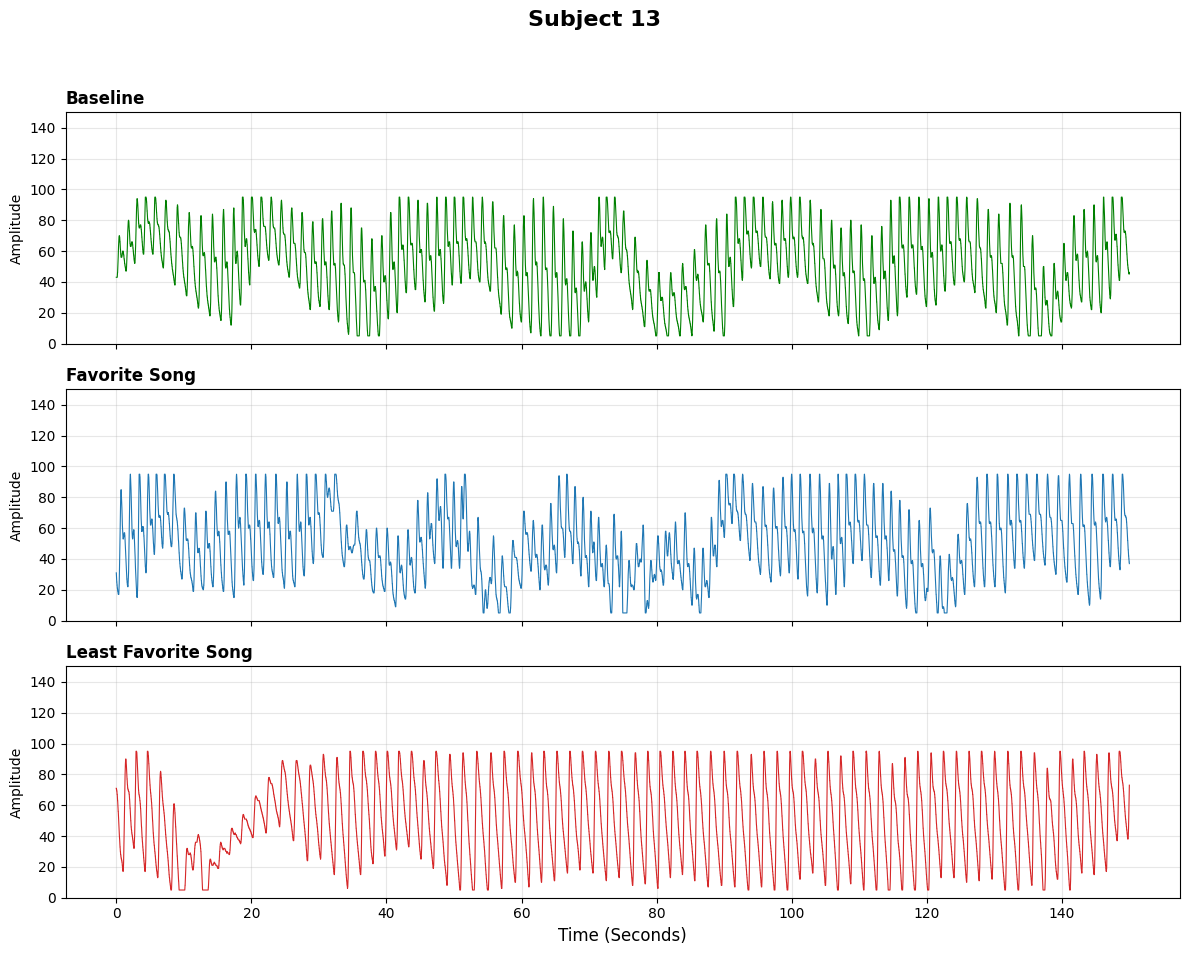

In [11]:
# ==========================================
# 4. GROUP BY SUBJECT (SETS OF 3)
# ==========================================
subjects = []

# Loop through records in steps of 3
for i in range(0, len(processed_records), 3):
    batch = processed_records[i : i+3]

    # Only process if we have a full group of 3
    if len(batch) == 3:
        # Assume the name of the first record is the Subject Name
        subjects.append({
            'id': (i // 3) + 1,
            'name': batch[0]['Name'],
            'baseline': batch[0]['Signal'],
            'favorite': batch[1]['Signal'],
            'least_fav': batch[2]['Signal']
        })

print(f"Organized data into {len(subjects)} Subject Groups.")

# ==========================================
# 5. VISUALIZE (TIME IN SECONDS)
# ==========================================
print("\nGenerating Plots...")

for subj in subjects:
    # Create 3 subplots sharing the X-axis
    fig, axes = plt.subplots(3, 1, figsize=(12, 10), sharex=True)

    # Title for the whole figure
    fig.suptitle(f"Subject {subj['id']}", fontsize=16, fontweight='bold')

    # Define the 3 conditions to plot
    conditions = [
        ('Baseline', subj['baseline'], 'green'),
        ('Favorite Song', subj['favorite'], '#1f77b4'), # Blue
        ('Least Favorite Song', subj['least_fav'], '#d62728') # Red
    ]

    for idx, (label, signal, color) in enumerate(conditions):
        # 1. CUTOFF: Trim the noisy end of the signal
        if len(signal) > CUTOFF_SAMPLE:
            clean_sig = signal[:CUTOFF_SAMPLE]
        else:
            clean_sig = signal

        # 2. TIME AXIS: Convert sample index to Seconds
        time_axis = np.arange(len(clean_sig)) / FS

        # 3. PLOT
        axes[idx].plot(time_axis, clean_sig, color=color, linewidth=0.8)

        # Styling
        axes[idx].set_title(label, fontsize=12, fontweight='bold', loc='left')
        axes[idx].set_ylabel("Amplitude")
        axes[idx].grid(True, alpha=0.3)

        # 4. Y-AXIS LIMIT: Hide remaining large spikes
        axes[idx].set_ylim(0, 150)

    # Label the X-axis only on the bottom chart
    axes[2].set_xlabel("Time (Seconds)", fontsize=12)

    plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout to make room for suptitle
    plt.show()

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt, find_peaks
from scipy.stats import ttest_rel, friedmanchisquare, wilcoxon
from scipy.interpolate import interp1d
import re
import warnings
warnings.filterwarnings('ignore')

# ==========================================
# PARAMETERS
# ==========================================
FS = 100  # Sampling rate in Hz
SEGMENT_DURATION = 120  # seconds
TARGET_SAMPLES = FS * SEGMENT_DURATION

# Filter settings
LOWCUT = 0.5
HIGHCUT = 8.0
FILTER_ORDER = 4

# Peak detection settings
MIN_PEAK_DISTANCE = 0.4  # seconds (max ~150 BPM)
PEAK_HEIGHT_PERCENTILE = 50  # adaptive threshold

# HRV frequency bands
VLF_BAND = (0.003, 0.04)  # Very Low Frequency
LF_BAND = (0.04, 0.15)    # Low Frequency (sympathetic + parasympathetic)
HF_BAND = (0.15, 0.4)     # High Frequency (parasympathetic)

CONDITIONS = ['baseline', 'favorite_song', 'least_favorite_song']

In [13]:
# ==========================================
# SIGNAL PROCESSING FUNCTIONS
# ==========================================
def bandpass_filter(signal, fs=FS, lowcut=LOWCUT, highcut=HIGHCUT, order=FILTER_ORDER):
    nyquist = fs / 2
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    return filtfilt(b, a, signal)


def normalize_signal(signal, method='zscore'):
    if method == 'zscore':
        return (signal - np.mean(signal)) / np.std(signal)
    elif method == 'minmax':
        return (signal - np.min(signal)) / (np.max(signal) - np.min(signal))


def extract_segment(signal, duration_sec=SEGMENT_DURATION, fs=FS, method='middle'):
    target_samples = int(duration_sec * fs)
    if len(signal) < target_samples:
        return None
    if method == 'middle':
        start = (len(signal) - target_samples) // 2
    elif method == 'start':
        start = 0
    elif method == 'end':
        start = len(signal) - target_samples
    return signal[start:start + target_samples]


def process_ppg_for_hrv(signal, fs=FS, segment_duration=SEGMENT_DURATION, method='middle'):
    segment = extract_segment(signal, segment_duration, fs, method)
    if segment is None:
        return None, None
    raw_segment = segment.copy()
    filtered = bandpass_filter(segment, fs)
    normalized = normalize_signal(filtered, method='zscore')
    return raw_segment, normalized

In [14]:
# ==========================================
# PEAK DETECTION
# ==========================================
def detect_peaks(signal, fs=FS, min_distance=MIN_PEAK_DISTANCE):
    """
    Detect systolic peaks in PPG signal.
    Returns peak indices and inter-beat intervals (IBI) in ms.
    """
    min_samples = int(min_distance * fs)
    height_thresh = np.percentile(signal, PEAK_HEIGHT_PERCENTILE)

    peaks, properties = find_peaks(signal, distance=min_samples, height=height_thresh, prominence=0.3)

    # Calculate IBI in milliseconds
    if len(peaks) > 1:
        ibi_samples = np.diff(peaks)
        ibi_ms = (ibi_samples / fs) * 1000
    else:
        ibi_ms = np.array([])

    return peaks, ibi_ms

def clean_ibi(ibi_ms, min_ibi=400, max_ibi=1500, max_change=0.2):
    """
    Remove artifacts from IBI series.
    - Physiological limits: 400-1500ms (40-150 BPM)
    - Max beat-to-beat change: 20%
    """
    if len(ibi_ms) < 2:
        return ibi_ms

    clean = []
    for i, ibi in enumerate(ibi_ms):
        # Check physiological limits
        if ibi < min_ibi or ibi > max_ibi:
            continue
        # Check beat-to-beat change
        if i > 0 and len(clean) > 0:
            change = abs(ibi - clean[-1]) / clean[-1]
            if change > max_change:
                continue
        clean.append(ibi)

    return np.array(clean)

# ==========================================
# HRV METRICS - TIME DOMAIN
# ==========================================
def calculate_time_domain_hrv(ibi_ms):
    """
    Calculate time-domain HRV metrics.
    """
    if len(ibi_ms) < 2:
        return None

    ibi_s = ibi_ms / 1000  # Convert to seconds
    diff_ibi = np.diff(ibi_ms)

    metrics = {
        # Basic statistics
        'mean_hr': 60000 / np.mean(ibi_ms),  # BPM
        'std_hr': 60000 / np.std(ibi_ms) if np.std(ibi_ms) > 0 else 0,
        'mean_ibi': np.mean(ibi_ms),  # ms

        # Standard HRV metrics
        'sdnn': np.std(ibi_ms, ddof=1),  # ms - overall variability
        'rmssd': np.sqrt(np.mean(diff_ibi ** 2)),  # ms - parasympathetic
        'sdsd': np.std(diff_ibi, ddof=1),  # ms

        # pNNxx metrics
        'nn50': np.sum(np.abs(diff_ibi) > 50),  # count
        'pnn50': (np.sum(np.abs(diff_ibi) > 50) / len(diff_ibi)) * 100,  # %
        'nn20': np.sum(np.abs(diff_ibi) > 20),  # count
        'pnn20': (np.sum(np.abs(diff_ibi) > 20) / len(diff_ibi)) * 100,  # %

        # Range metrics
        'ibi_range': np.max(ibi_ms) - np.min(ibi_ms),  # ms
        'cv': (np.std(ibi_ms) / np.mean(ibi_ms)) * 100,  # coefficient of variation %
    }

    return metrics

# ==========================================
# HRV METRICS - FREQUENCY DOMAIN
# ==========================================
def calculate_frequency_domain_hrv(ibi_ms, fs_resample=4):
    """
    Calculate frequency-domain HRV metrics using Welch's method.
    """
    if len(ibi_ms) < 10:
        return None

    # Create time vector for IBI series
    ibi_times = np.cumsum(ibi_ms) / 1000  # Convert to seconds
    ibi_times = ibi_times - ibi_times[0]  # Start from 0

    # Interpolate to uniform sampling
    interp_func = interp1d(ibi_times, ibi_ms, kind='cubic', fill_value='extrapolate')
    t_uniform = np.arange(0, ibi_times[-1], 1/fs_resample)
    ibi_uniform = interp_func(t_uniform)

    # Remove mean (detrend)
    ibi_uniform = ibi_uniform - np.mean(ibi_uniform)

    # Compute FFT
    n = len(ibi_uniform)
    fft_vals = np.fft.fft(ibi_uniform)
    fft_freq = np.fft.fftfreq(n, 1/fs_resample)

    # Power spectrum (one-sided)
    pos_mask = fft_freq >= 0
    freqs = fft_freq[pos_mask]
    psd = (np.abs(fft_vals[pos_mask]) ** 2) / n

    # Calculate band powers
    def band_power(freqs, psd, band):
        mask = (freqs >= band[0]) & (freqs < band[1])
        return np.trapz(psd[mask], freqs[mask]) if np.any(mask) else 0

    vlf_power = band_power(freqs, psd, VLF_BAND)
    lf_power = band_power(freqs, psd, LF_BAND)
    hf_power = band_power(freqs, psd, HF_BAND)
    total_power = vlf_power + lf_power + hf_power

    metrics = {
        'vlf_power': vlf_power,  # ms²
        'lf_power': lf_power,    # ms² - sympathetic + parasympathetic
        'hf_power': hf_power,    # ms² - parasympathetic (respiratory)
        'total_power': total_power,
        'lf_norm': (lf_power / (lf_power + hf_power)) * 100 if (lf_power + hf_power) > 0 else 0,
        'hf_norm': (hf_power / (lf_power + hf_power)) * 100 if (lf_power + hf_power) > 0 else 0,
        'lf_hf_ratio': lf_power / hf_power if hf_power > 0 else 0,  # Sympathovagal balance
    }

    return metrics, freqs, psd

# ==========================================
# COMPLETE HRV ANALYSIS
# ==========================================
def analyze_hrv(signal, fs=FS, name="Signal"):
    """
    Complete HRV analysis pipeline.
    """
    # Detect peaks
    peaks, ibi_ms = detect_peaks(signal, fs)

    if len(ibi_ms) < 5:
        print(f"  Warning: Too few beats detected for {name}")
        return None

    # Clean IBI series
    ibi_clean = clean_ibi(ibi_ms)

    if len(ibi_clean) < 5:
        print(f"  Warning: Too few clean beats for {name}")
        return None

    # Calculate metrics
    time_metrics = calculate_time_domain_hrv(ibi_clean)
    freq_result = calculate_frequency_domain_hrv(ibi_clean)

    if freq_result is None:
        freq_metrics = {}
        freqs, psd = None, None
    else:
        freq_metrics, freqs, psd = freq_result

    return {
        'peaks': peaks,
        'ibi_raw': ibi_ms,
        'ibi_clean': ibi_clean,
        'time_domain': time_metrics,
        'freq_domain': freq_metrics,
        'psd_freqs': freqs,
        'psd_power': psd
    }

In [15]:
# ==========================================
# DATA ORGANIZATION FUNCTIONS
# ==========================================
def extract_file_number(name):
    match = re.search(r'(\d+)', name)
    return int(match.group(1)) if match else None


def organize_by_subject(processed_records, start_id=12, measurements_per_subject=3):
    subjects = {}
    sorted_records = sorted(processed_records, key=lambda x: extract_file_number(x['Name']) or 0)
    filtered_records = [r for r in sorted_records if (extract_file_number(r['Name']) or 0) >= start_id]

    print(f"Found {len(filtered_records)} records starting from ID {start_id}")

    subject_num = 1
    for i in range(0, len(filtered_records), measurements_per_subject):
        subject_measurements = filtered_records[i:i + measurements_per_subject]
        if len(subject_measurements) == measurements_per_subject:
            subjects[subject_num] = {
                'baseline': subject_measurements[0],
                'favorite_song': subject_measurements[1],
                'least_favorite_song': subject_measurements[2],
                'file_ids': [extract_file_number(m['Name']) for m in subject_measurements]
            }
            subject_num += 1

    return subjects

# ==========================================
# VISUALIZATION FUNCTIONS
# ==========================================
def plot_peaks_detection(signal, peaks, ibi_ms, fs=FS, name="Signal", show_seconds=15):
    """Visualize peak detection results."""
    samples = int(show_seconds * fs)
    time = np.arange(samples) / fs

    # Find peaks within display window
    peaks_in_window = peaks[peaks < samples]

    fig, axes = plt.subplots(2, 1, figsize=(14, 6))
    fig.suptitle(f'Peak Detection: {name}', fontsize=12, fontweight='bold')

    # Signal with peaks
    axes[0].plot(time, signal[:samples], 'teal', linewidth=0.8, label='PPG Signal')
    axes[0].scatter(peaks_in_window / fs, signal[peaks_in_window], color='red', s=50, zorder=5, label='Detected Peaks')
    axes[0].set_ylabel('Normalized Amplitude')
    axes[0].set_xlabel('Time (s)')
    axes[0].legend(loc='upper right')
    axes[0].grid(True, alpha=0.3)

    # IBI tachogram
    if len(ibi_ms) > 0:
        axes[1].plot(ibi_ms, 'o-', color='purple', markersize=4, linewidth=1)
        axes[1].axhline(np.mean(ibi_ms), color='red', linestyle='--', label=f'Mean: {np.mean(ibi_ms):.0f} ms')
        axes[1].set_ylabel('IBI (ms)')
        axes[1].set_xlabel('Beat Number')
        axes[1].legend()
        axes[1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()


def plot_subject_hrv_comparison(hrv_results, subject_id):
    """Plot HRV comparison across conditions for one subject."""
    fig, axes = plt.subplots(2, 3, figsize=(15, 8))
    fig.suptitle(f'Subject {subject_id} - HRV Analysis Across Conditions', fontsize=14, fontweight='bold')

    colors = {'baseline': 'gray', 'favorite_song': 'green', 'least_favorite_song': 'red'}
    labels = {'baseline': 'Baseline', 'favorite_song': 'Favorite', 'least_favorite_song': 'Least Fav'}

    # Row 1: IBI tachograms
    for i, cond in enumerate(CONDITIONS):
        if cond in hrv_results and hrv_results[cond] is not None:
            ibi = hrv_results[cond]['ibi_clean']
            axes[0, i].plot(ibi, 'o-', color=colors[cond], markersize=3, linewidth=0.8)
            axes[0, i].axhline(np.mean(ibi), color='black', linestyle='--', alpha=0.5)
            axes[0, i].set_title(f'{labels[cond]}\nMean IBI: {np.mean(ibi):.0f} ms')
            axes[0, i].set_ylabel('IBI (ms)')
            axes[0, i].set_xlabel('Beat #')
            axes[0, i].grid(True, alpha=0.3)

    # Row 2: Power Spectral Density
    for i, cond in enumerate(CONDITIONS):
        if cond in hrv_results and hrv_results[cond] is not None:
            freqs = hrv_results[cond]['psd_freqs']
            psd = hrv_results[cond]['psd_power']
            if freqs is not None:
                mask = freqs < 0.5
                axes[1, i].fill_between(freqs[mask], psd[mask], alpha=0.3, color=colors[cond])
                axes[1, i].plot(freqs[mask], psd[mask], color=colors[cond], linewidth=1)
                axes[1, i].axvspan(LF_BAND[0], LF_BAND[1], alpha=0.1, color='blue', label='LF')
                axes[1, i].axvspan(HF_BAND[0], HF_BAND[1], alpha=0.1, color='green', label='HF')
                axes[1, i].set_xlabel('Frequency (Hz)')
                axes[1, i].set_ylabel('Power (ms²)')
                axes[1, i].set_title(f'PSD - {labels[cond]}')
                axes[1, i].legend(loc='upper right')
                axes[1, i].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()


def plot_group_statistics(all_hrv_data):
    """Plot group-level HRV statistics."""
    # Collect metrics across all subjects
    metrics_to_plot = ['mean_hr', 'sdnn', 'rmssd', 'pnn50', 'lf_hf_ratio', 'hf_power']
    metric_labels = ['Heart Rate\n(BPM)', 'SDNN\n(ms)', 'RMSSD\n(ms)', 'pNN50\n(%)', 'LF/HF\nRatio', 'HF Power\n(ms²)']

    # Organize data by condition
    condition_data = {cond: {m: [] for m in metrics_to_plot} for cond in CONDITIONS}

    for subj_id, hrv_results in all_hrv_data.items():
        for cond in CONDITIONS:
            if hrv_results[cond] is not None:
                td = hrv_results[cond]['time_domain']
                fd = hrv_results[cond]['freq_domain']
                if td:
                    for m in ['mean_hr', 'sdnn', 'rmssd', 'pnn50']:
                        if m in td:
                            condition_data[cond][m].append(td[m])
                if fd:
                    for m in ['lf_hf_ratio', 'hf_power']:
                        if m in fd:
                            condition_data[cond][m].append(fd[m])

    # Create bar plot
    fig, axes = plt.subplots(2, 3, figsize=(14, 8))
    axes = axes.flatten()
    fig.suptitle('Group HRV Statistics by Condition (Mean ± SEM)', fontsize=14, fontweight='bold')

    colors = ['gray', 'green', 'red']
    cond_labels = ['Baseline', 'Favorite', 'Least Fav']

    for i, (metric, label) in enumerate(zip(metrics_to_plot, metric_labels)):
        means = []
        sems = []
        for cond in CONDITIONS:
            data = condition_data[cond][metric]
            if len(data) > 0:
                means.append(np.mean(data))
                sems.append(np.std(data) / np.sqrt(len(data)))
            else:
                means.append(0)
                sems.append(0)

        x = np.arange(3)
        bars = axes[i].bar(x, means, yerr=sems, color=colors, capsize=5, alpha=0.7)
        axes[i].set_xticks(x)
        axes[i].set_xticklabels(cond_labels)
        axes[i].set_ylabel(label)
        axes[i].grid(True, alpha=0.3, axis='y')

    plt.tight_layout()
    plt.show()

    return condition_data

# ==========================================
# STATISTICAL ANALYSIS
# ==========================================
def run_statistical_tests(condition_data):
    """Run statistical tests comparing conditions."""
    print("\n" + "=" * 70)
    print("STATISTICAL ANALYSIS")
    print("=" * 70)

    metrics = ['mean_hr', 'sdnn', 'rmssd', 'pnn50', 'lf_hf_ratio', 'hf_power']
    metric_names = ['Heart Rate', 'SDNN', 'RMSSD', 'pNN50', 'LF/HF Ratio', 'HF Power']

    results = {}

    for metric, name in zip(metrics, metric_names):
        print(f"\n{name}:")
        print("-" * 50)

        baseline = np.array(condition_data['baseline'][metric])
        favorite = np.array(condition_data['favorite_song'][metric])
        least_fav = np.array(condition_data['least_favorite_song'][metric])

        # Need matched samples
        n = min(len(baseline), len(favorite), len(least_fav))
        if n < 3:
            print("  Insufficient data for statistical tests")
            continue

        baseline = baseline[:n]
        favorite = favorite[:n]
        least_fav = least_fav[:n]

        # Descriptive stats
        print(f"  Baseline:     {np.mean(baseline):8.2f} ± {np.std(baseline):.2f}")
        print(f"  Favorite:     {np.mean(favorite):8.2f} ± {np.std(favorite):.2f}")
        print(f"  Least Fav:    {np.mean(least_fav):8.2f} ± {np.std(least_fav):.2f}")

        # Friedman test (non-parametric repeated measures)
        try:
            stat, p_friedman = friedmanchisquare(baseline, favorite, least_fav)
            print(f"\n  Friedman test: χ² = {stat:.3f}, p = {p_friedman:.4f}", end="")
            print(" *" if p_friedman < 0.05 else "")
        except:
            p_friedman = None

        # Pairwise Wilcoxon tests
        print("\n  Pairwise comparisons (Wilcoxon):")
        pairs = [
            ('Baseline vs Favorite', baseline, favorite),
            ('Baseline vs Least Fav', baseline, least_fav),
            ('Favorite vs Least Fav', favorite, least_fav)
        ]

        for pair_name, g1, g2 in pairs:
            try:
                stat, p = wilcoxon(g1, g2)
                sig = "*" if p < 0.05 else ""
                print(f"    {pair_name}: p = {p:.4f} {sig}")
            except:
                print(f"    {pair_name}: Could not compute")

        results[metric] = {
            'baseline': baseline, 'favorite': favorite, 'least_fav': least_fav,
            'friedman_p': p_friedman
        }

    return results

COMPLETE PPG-HRV ANALYSIS PIPELINE
Settings: 120s, 0.5-8.0Hz filter, 10 subjects × 3 conditions

[STEP 1] Processing PPG signals...
Processed 41 records

[STEP 2] Organizing by subject...
Found 41 records starting from ID 0
Organized into 13 subjects

[STEP 3] Running HRV analysis...

  Subject 1:
    baseline            : HR=55.3 bpm, SDNN=112.8 ms, RMSSD=91.1 ms
    favorite_song       : HR=120.5 bpm, SDNN=51.8 ms, RMSSD=54.1 ms
    least_favorite_song : HR=60.4 bpm, SDNN=366.3 ms, RMSSD=115.1 ms

  Subject 2:
    baseline            : HR=56.2 bpm, SDNN=219.9 ms, RMSSD=115.3 ms
    favorite_song       : HR=46.9 bpm, SDNN=90.1 ms, RMSSD=81.5 ms
    least_favorite_song : HR=50.0 bpm, SDNN=127.1 ms, RMSSD=81.3 ms

  Subject 3:
    baseline            : HR=48.1 bpm, SDNN=98.0 ms, RMSSD=65.8 ms
    favorite_song       : HR=49.4 bpm, SDNN=117.0 ms, RMSSD=87.2 ms

  Subject 4:
    baseline            : HR=54.8 bpm, SDNN=168.8 ms, RMSSD=105.6 ms
    favorite_song       : HR=44.1 bpm, SDNN=74

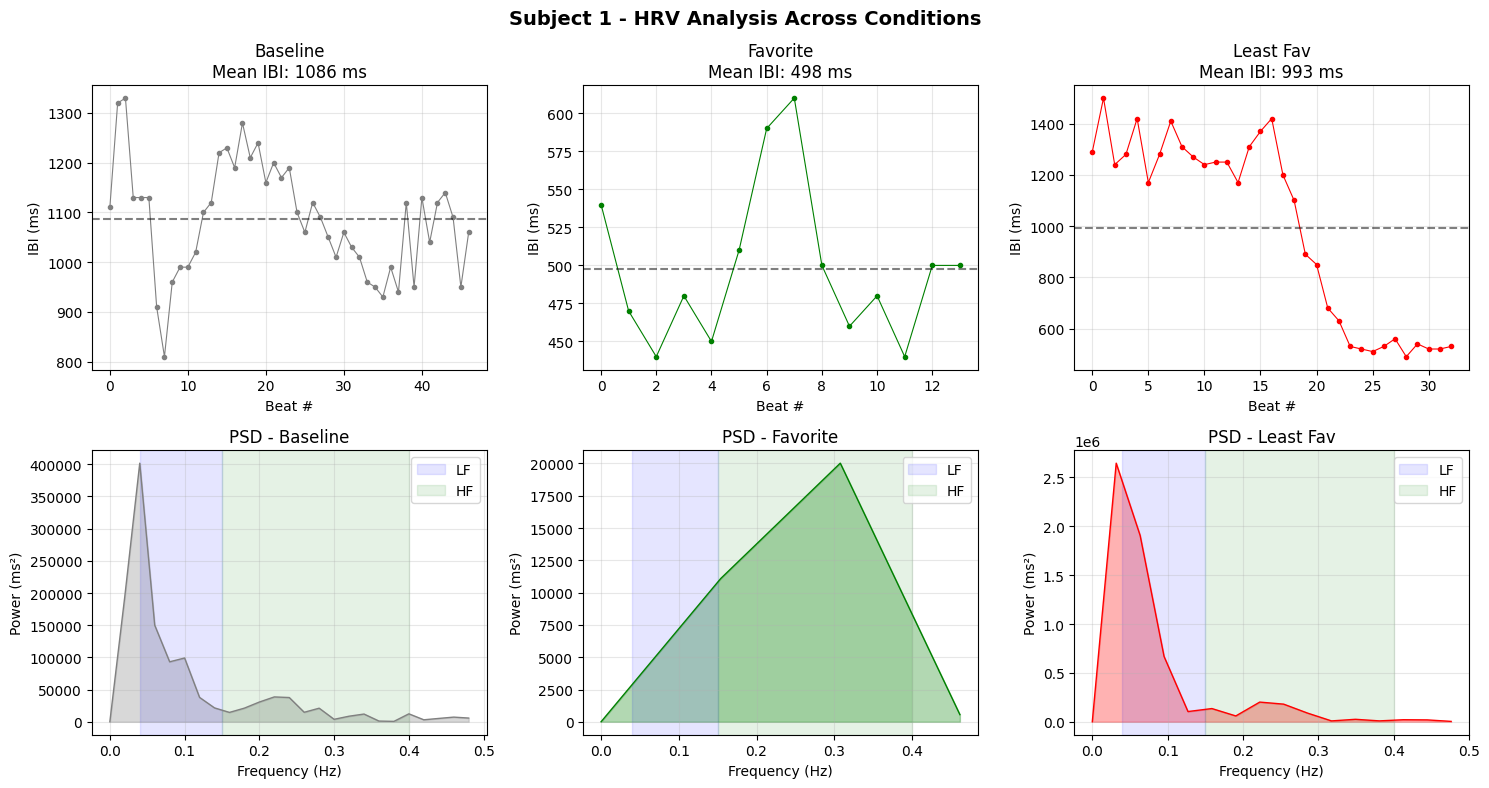

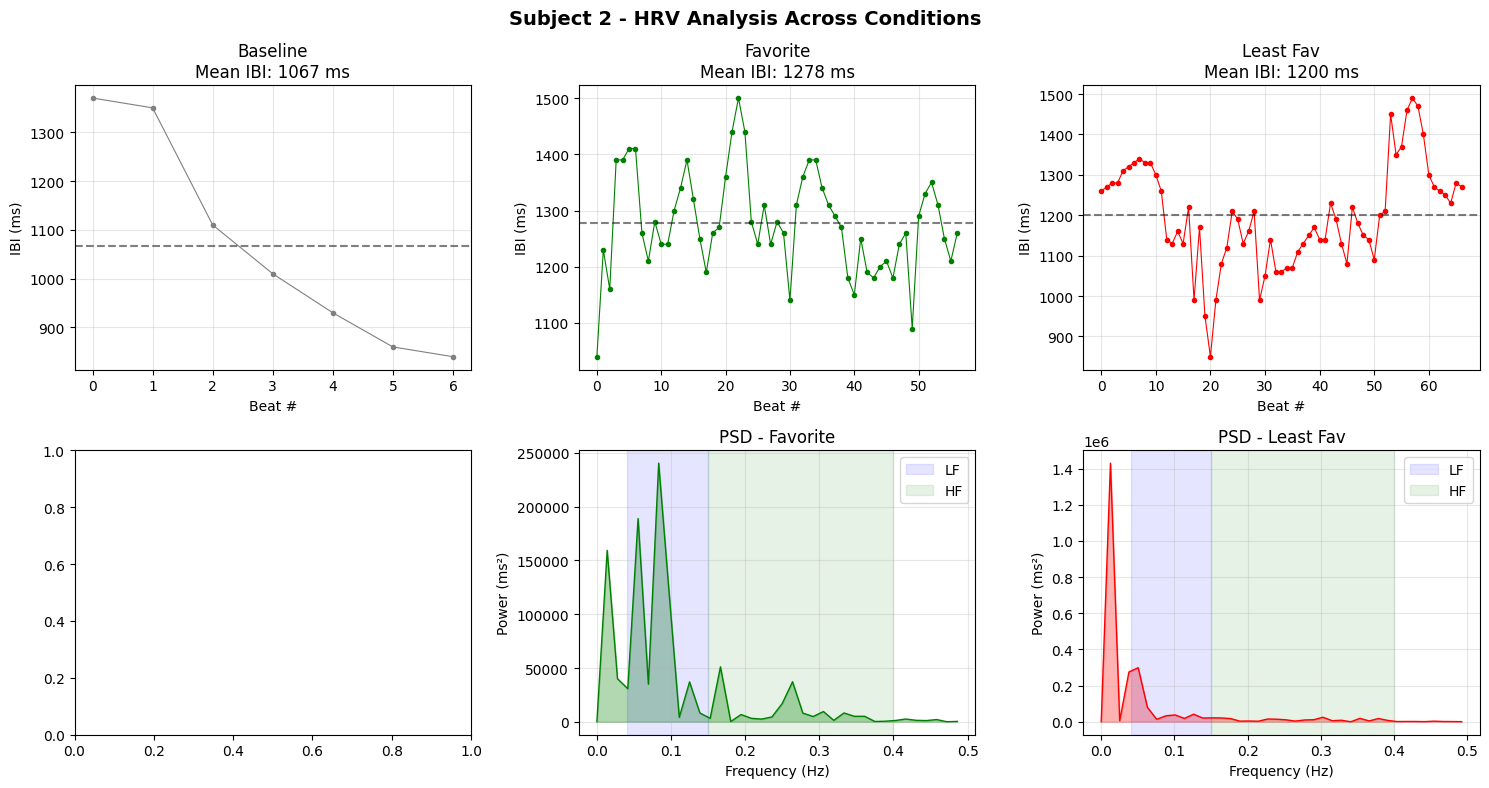


[STEP 5] Computing group statistics...


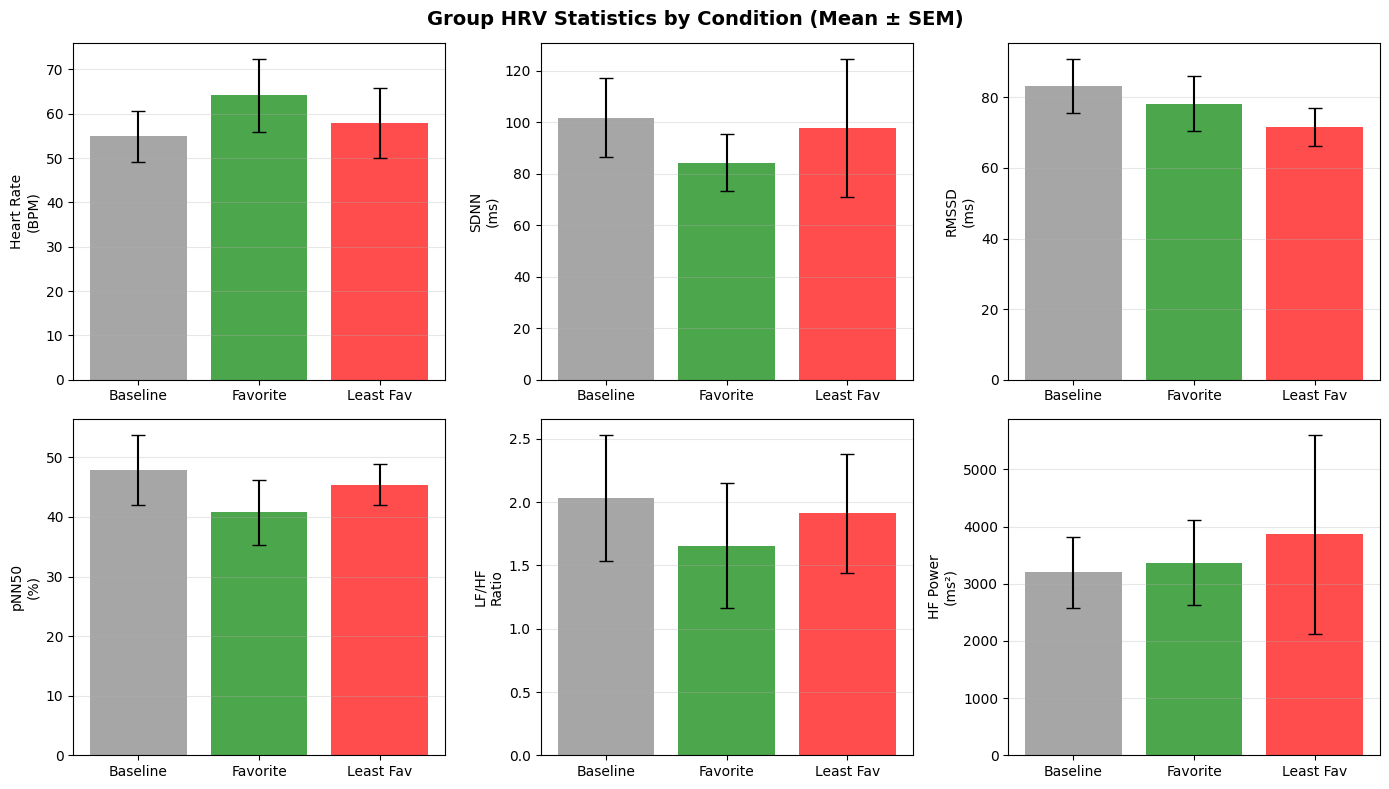


STATISTICAL ANALYSIS

Heart Rate:
--------------------------------------------------
  Baseline:        54.93 ± 18.97
  Favorite:        60.40 ± 26.64
  Least Fav:       57.92 ± 25.87

  Friedman test: χ² = 3.818, p = 0.1482

  Pairwise comparisons (Wilcoxon):
    Baseline vs Favorite: p = 0.7002 
    Baseline vs Least Fav: p = 0.2061 
    Favorite vs Least Fav: p = 0.4648 

SDNN:
--------------------------------------------------
  Baseline:       101.77 ± 51.06
  Favorite:        89.87 ± 35.29
  Least Fav:       97.65 ± 89.12

  Friedman test: χ² = 0.545, p = 0.7613

  Pairwise comparisons (Wilcoxon):
    Baseline vs Favorite: p = 0.7002 
    Baseline vs Least Fav: p = 0.3203 
    Favorite vs Least Fav: p = 0.5771 

RMSSD:
--------------------------------------------------
  Baseline:        83.21 ± 25.41
  Favorite:        82.26 ± 24.38
  Least Fav:       71.65 ± 18.03

  Friedman test: χ² = 4.545, p = 0.1030

  Pairwise comparisons (Wilcoxon):
    Baseline vs Favorite: p = 0.5771 

In [16]:
# ==========================================
# MAIN EXECUTION
# ==========================================
print("=" * 70)
print("COMPLETE PPG-HRV ANALYSIS PIPELINE")
print(f"Settings: {SEGMENT_DURATION}s, {LOWCUT}-{HIGHCUT}Hz filter, 10 subjects × 3 conditions")
print("=" * 70)

# STEP 1: Process all signals
print("\n[STEP 1] Processing PPG signals...")
processed_ppg_records = []

for record in processed_records:
    name = record['Name']
    raw_signal = record['Signal']
    raw_segment, processed_signal = process_ppg_for_hrv(raw_signal)

    if processed_signal is not None:
        processed_ppg_records.append({
            'Name': name,
            'Signal': processed_signal,
            'Raw': raw_segment
        })

print(f"Processed {len(processed_ppg_records)} records")

# STEP 2: Organize by subject
print("\n[STEP 2] Organizing by subject...")
# Fix: Change start_id from 12 to 0 to include all records, as extract_file_number
# returns 0 for names without numerical IDs (e.g., 'Andras', 'Anna', 'Sofia').
# Note: This assumes the processed_ppg_records are sequentially ordered for conditions
# (baseline, favorite_song, least_favorite_song) within each conceptual subject group.
subjects_data = organize_by_subject(processed_ppg_records, start_id=0)
print(f"Organized into {len(subjects_data)} subjects")

# STEP 3: Run HRV analysis for all subjects
print("\n[STEP 3] Running HRV analysis...")
all_hrv_data = {}

for subj_id, subj_data in subjects_data.items():
    print(f"\n  Subject {subj_id}:")
    hrv_results = {}

    for cond in CONDITIONS:
        signal = subj_data[cond]['Signal']
        hrv = analyze_hrv(signal, name=f"S{subj_id}-{cond}")
        hrv_results[cond] = hrv

        if hrv:
            td = hrv['time_domain']
            print(f"    {cond:20s}: HR={td['mean_hr']:.1f} bpm, SDNN={td['sdnn']:.1f} ms, RMSSD={td['rmssd']:.1f} ms")

    all_hrv_data[subj_id] = hrv_results

# STEP 4: Visualizations
print("\n[STEP 4] Generating visualizations...")

# Show peak detection for first subject's baseline
first_subj = subjects_data[1]
signal = first_subj['baseline']['Signal']
peaks, ibi = detect_peaks(signal)
plot_peaks_detection(signal, peaks, ibi, name="Subject 1 - Baseline")

# Show HRV comparison for first 2 subjects
for subj_id in [1, 2]:
    if subj_id in all_hrv_data:
        plot_subject_hrv_comparison(all_hrv_data[subj_id], subj_id)

# STEP 5: Group statistics
print("\n[STEP 5] Computing group statistics...")
condition_data = plot_group_statistics(all_hrv_data)

# STEP 6: Statistical tests
stats_results = run_statistical_tests(condition_data)

print("\n" + "=" * 70)
print("ANALYSIS COMPLETE")
print("=" * 70)

COMPLETE PPG-HRV ANALYSIS PIPELINE
Settings: 120s, 0.5-8.0Hz filter, 10 subjects × 3 conditions

[STEP 1] Processing PPG signals...
Processed 41 records

[STEP 2] Organizing by subject...
Found 41 records starting from ID 0
Organized into 13 subjects

[STEP 3] Running HRV analysis...

  Subject 1:
    baseline            : HR=55.3 bpm, SDNN=112.8 ms, RMSSD=91.1 ms
    favorite_song       : HR=120.5 bpm, SDNN=51.8 ms, RMSSD=54.1 ms
    least_favorite_song : HR=60.4 bpm, SDNN=366.3 ms, RMSSD=115.1 ms

  Subject 2:
    baseline            : HR=56.2 bpm, SDNN=219.9 ms, RMSSD=115.3 ms
    favorite_song       : HR=46.9 bpm, SDNN=90.1 ms, RMSSD=81.5 ms
    least_favorite_song : HR=50.0 bpm, SDNN=127.1 ms, RMSSD=81.3 ms

  Subject 3:
    baseline            : HR=48.1 bpm, SDNN=98.0 ms, RMSSD=65.8 ms
    favorite_song       : HR=49.4 bpm, SDNN=117.0 ms, RMSSD=87.2 ms

  Subject 4:
    baseline            : HR=54.8 bpm, SDNN=168.8 ms, RMSSD=105.6 ms
    favorite_song       : HR=44.1 bpm, SDNN=74

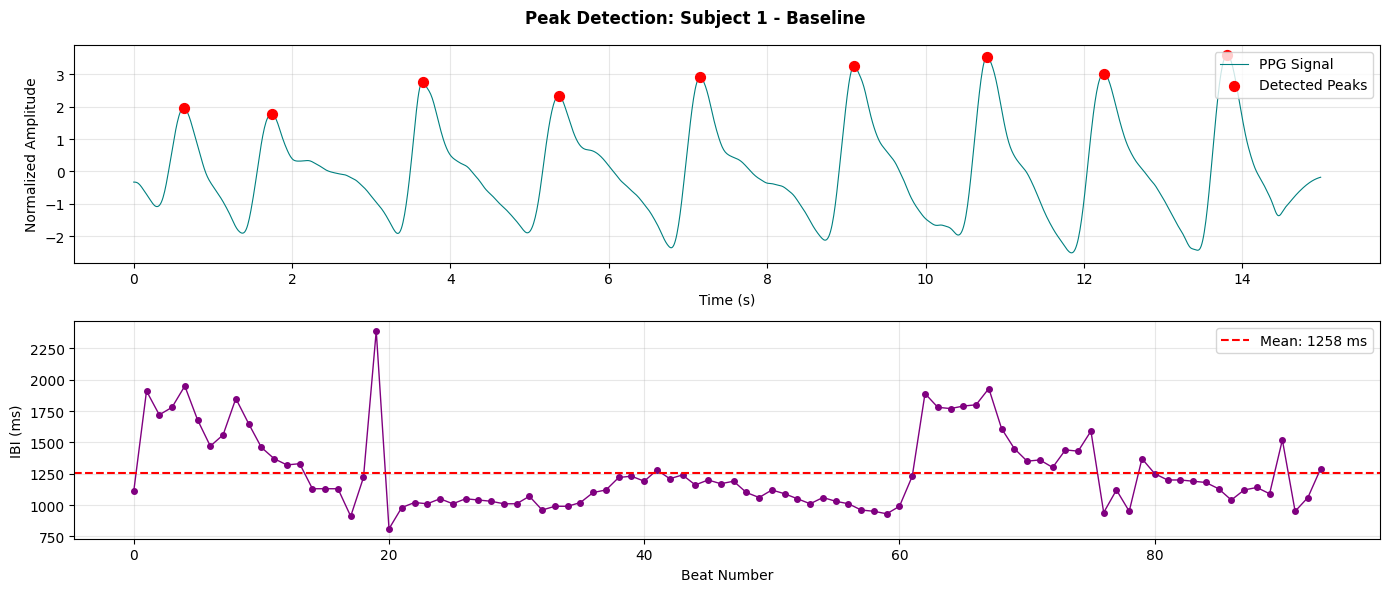

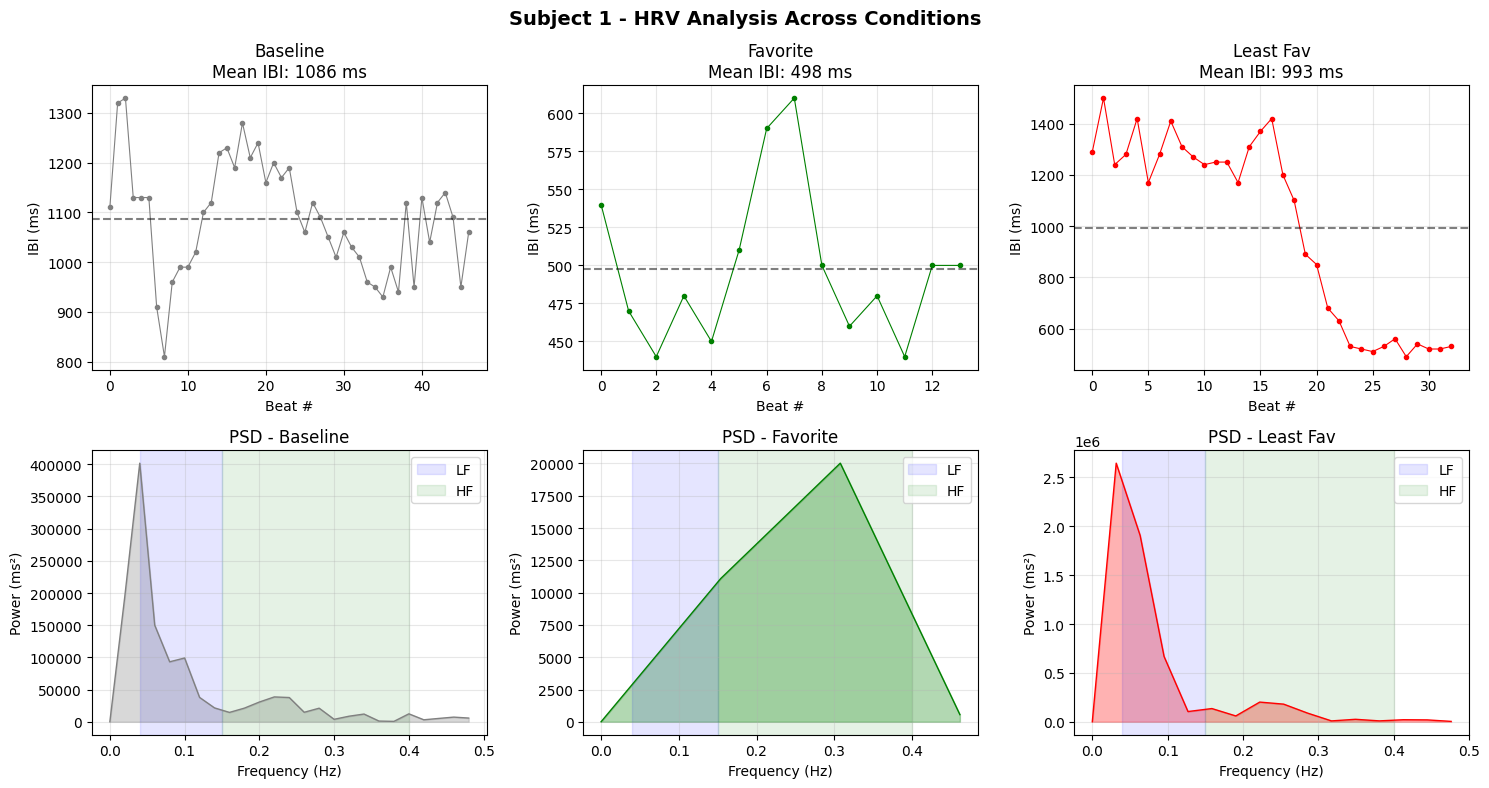

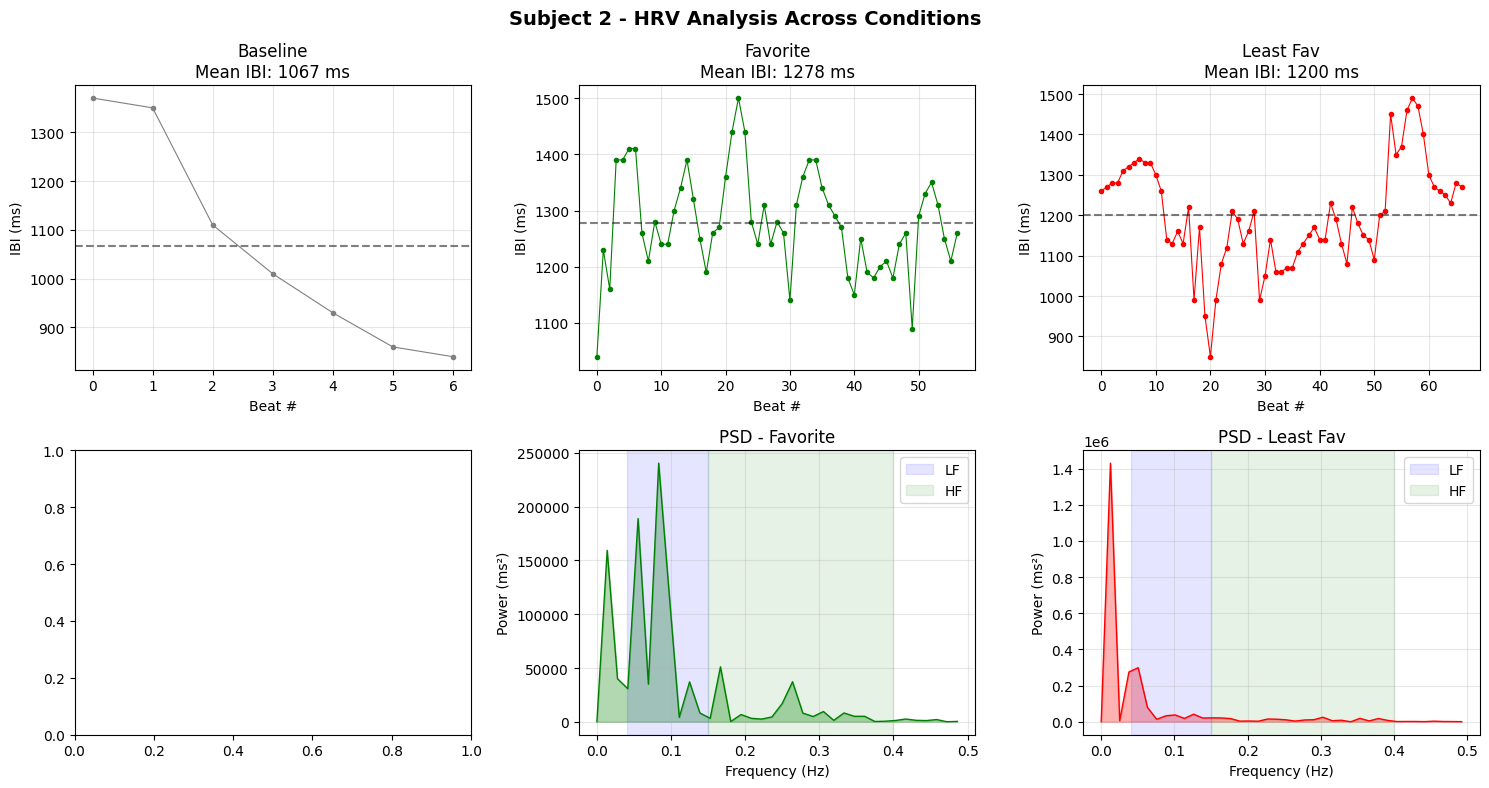


[STEP 5] Computing group statistics...


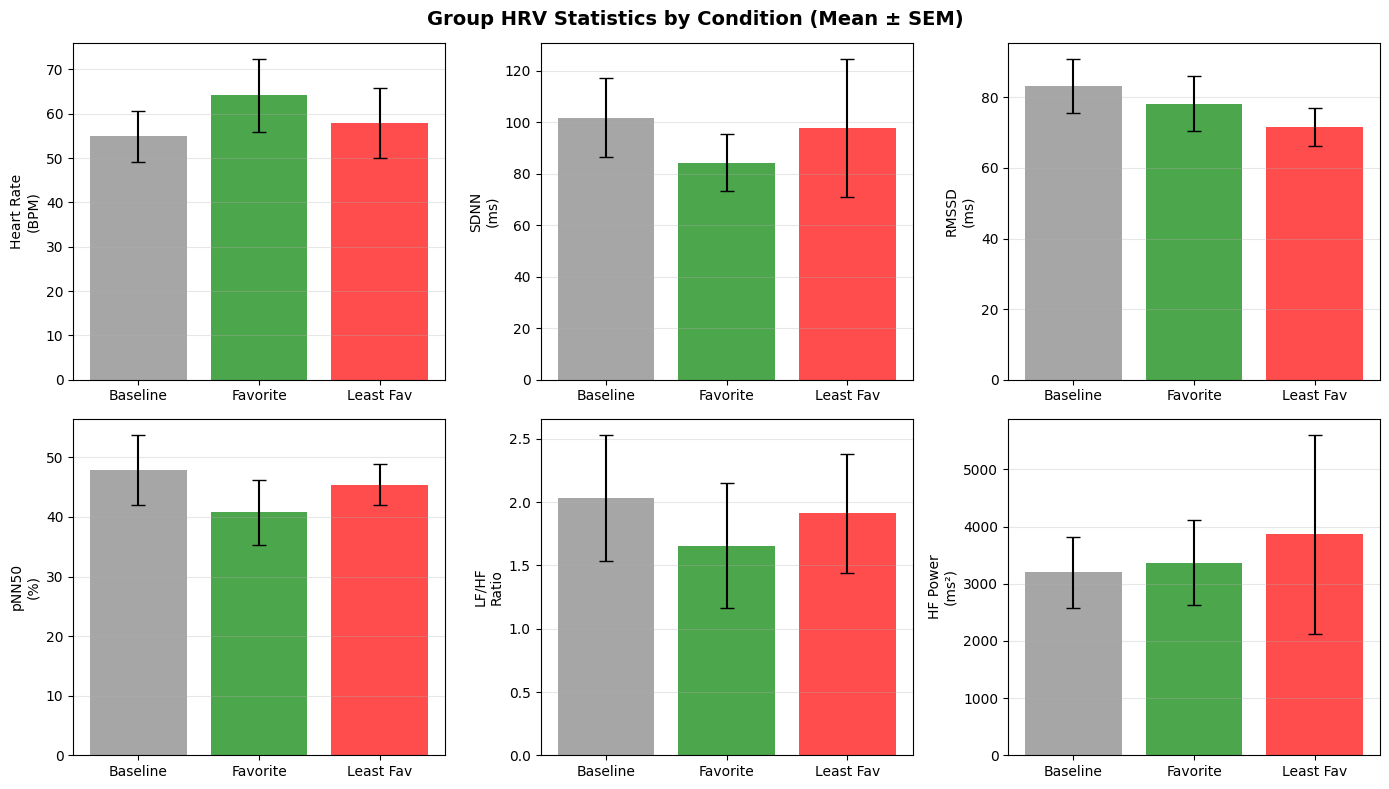


STATISTICAL ANALYSIS

Heart Rate:
--------------------------------------------------
  Baseline:        54.93 ± 18.97
  Favorite:        60.40 ± 26.64
  Least Fav:       57.92 ± 25.87

  Friedman test: χ² = 3.818, p = 0.1482

  Pairwise comparisons (Wilcoxon):
    Baseline vs Favorite: p = 0.7002 
    Baseline vs Least Fav: p = 0.2061 
    Favorite vs Least Fav: p = 0.4648 

SDNN:
--------------------------------------------------
  Baseline:       101.77 ± 51.06
  Favorite:        89.87 ± 35.29
  Least Fav:       97.65 ± 89.12

  Friedman test: χ² = 0.545, p = 0.7613

  Pairwise comparisons (Wilcoxon):
    Baseline vs Favorite: p = 0.7002 
    Baseline vs Least Fav: p = 0.3203 
    Favorite vs Least Fav: p = 0.5771 

RMSSD:
--------------------------------------------------
  Baseline:        83.21 ± 25.41
  Favorite:        82.26 ± 24.38
  Least Fav:       71.65 ± 18.03

  Friedman test: χ² = 4.545, p = 0.1030

  Pairwise comparisons (Wilcoxon):
    Baseline vs Favorite: p = 0.5771 

In [17]:
# ==========================================
# MAIN EXECUTION
# ==========================================
print("=" * 70)
print("COMPLETE PPG-HRV ANALYSIS PIPELINE")
print(f"Settings: {SEGMENT_DURATION}s, {LOWCUT}-{HIGHCUT}Hz filter, 10 subjects × 3 conditions")
print("=" * 70)

# STEP 1: Process all signals
print("\n[STEP 1] Processing PPG signals...")
processed_ppg_records = []

for record in processed_records:
    name = record['Name']
    raw_signal = record['Signal']
    raw_segment, processed_signal = process_ppg_for_hrv(raw_signal)

    if processed_signal is not None:
        processed_ppg_records.append({
            'Name': name,
            'Signal': processed_signal,
            'Raw': raw_segment
        })

print(f"Processed {len(processed_ppg_records)} records")

# STEP 2: Organize by subject
print("\n[STEP 2] Organizing by subject...")
# Fix: Change start_id from 12 to 0 to include all records, as extract_file_number
# returns 0 for names without numerical IDs (e.g., 'Andras', 'Anna', 'Sofia').
# Note: This assumes the processed_ppg_records are sequentially ordered for conditions
# (baseline, favorite_song, least_favorite_song) within each conceptual subject group.
subjects_data = organize_by_subject(processed_ppg_records, start_id=0)
print(f"Organized into {len(subjects_data)} subjects")

# STEP 3: Run HRV analysis for all subjects
print("\n[STEP 3] Running HRV analysis...")
all_hrv_data = {}

for subj_id, subj_data in subjects_data.items():
    print(f"\n  Subject {subj_id}:")
    hrv_results = {}

    for cond in CONDITIONS:
        signal = subj_data[cond]['Signal']
        hrv = analyze_hrv(signal, name=f"S{subj_id}-{cond}")
        hrv_results[cond] = hrv

        if hrv:
            td = hrv['time_domain']
            print(f"    {cond:20s}: HR={td['mean_hr']:.1f} bpm, SDNN={td['sdnn']:.1f} ms, RMSSD={td['rmssd']:.1f} ms")

    all_hrv_data[subj_id] = hrv_results

# STEP 4: Visualizations
print("\n[STEP 4] Generating visualizations...")

# Show peak detection for first subject's baseline
first_subj = subjects_data[1]
signal = first_subj['baseline']['Signal']
peaks, ibi = detect_peaks(signal)
plot_peaks_detection(signal, peaks, ibi, name="Subject 1 - Baseline")

# Show HRV comparison for first 2 subjects
for subj_id in [1, 2]:
    if subj_id in all_hrv_data:
        plot_subject_hrv_comparison(all_hrv_data[subj_id], subj_id)

# STEP 5: Group statistics
print("\n[STEP 5] Computing group statistics...")
condition_data = plot_group_statistics(all_hrv_data)

# STEP 6: Statistical tests
stats_results = run_statistical_tests(condition_data)

print("\n" + "=" * 70)
print("ANALYSIS COMPLETE")
print("=" * 70)

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt, find_peaks
from scipy.stats import ttest_rel, friedmanchisquare, wilcoxon
from scipy.interpolate import interp1d
import warnings
warnings.filterwarnings('ignore')

# ==========================================
# PARAMETERS
# ==========================================
FS = 100  # Sampling rate in Hz
SEGMENT_DURATION = 120  # seconds
TARGET_SAMPLES = FS * SEGMENT_DURATION

# Filter settings
LOWCUT = 0.5
HIGHCUT = 8.0
FILTER_ORDER = 4

# Peak detection settings
MIN_PEAK_DISTANCE = 0.4  # seconds (max ~150 BPM)
PEAK_HEIGHT_PERCENTILE = 50  # adaptive threshold

# HRV frequency bands
VLF_BAND = (0.003, 0.04)  # Very Low Frequency
LF_BAND = (0.04, 0.15)    # Low Frequency (sympathetic + parasympathetic)
HF_BAND = (0.15, 0.4)     # High Frequency (parasympathetic)

CONDITIONS = ['baseline', 'favorite_song', 'least_favorite_song']

In [19]:
# ==========================================
# SIGNAL PROCESSING FUNCTIONS
# ==========================================
def bandpass_filter(signal, fs=FS, lowcut=LOWCUT, highcut=HIGHCUT, order=FILTER_ORDER):
    nyquist = fs / 2
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    return filtfilt(b, a, signal)


def normalize_signal(signal, method='zscore'):
    if method == 'zscore':
        return (signal - np.mean(signal)) / np.std(signal)
    elif method == 'minmax':
        return (signal - np.min(signal)) / (np.max(signal) - np.min(signal))


def extract_segment(signal, duration_sec=SEGMENT_DURATION, fs=FS, method='middle'):
    target_samples = int(duration_sec * fs)
    if len(signal) < target_samples:
        return None
    if method == 'middle':
        start = (len(signal) - target_samples) // 2
    elif method == 'start':
        start = 0
    elif method == 'end':
        start = len(signal) - target_samples
    return signal[start:start + target_samples]


def process_ppg_for_hrv(signal, fs=FS, segment_duration=SEGMENT_DURATION, method='middle'):
    segment = extract_segment(signal, segment_duration, fs, method)
    if segment is None:
        return None, None
    raw_segment = segment.copy()
    filtered = bandpass_filter(segment, fs)
    normalized = normalize_signal(filtered, method='zscore')
    return raw_segment, normalized


# ==========================================
# PEAK DETECTION
# ==========================================
def detect_peaks(signal, fs=FS, min_distance=MIN_PEAK_DISTANCE):
    """
    Detect systolic peaks in PPG signal.
    Returns peak indices and inter-beat intervals (IBI) in ms.
    """
    min_samples = int(min_distance * fs)
    height_thresh = np.percentile(signal, PEAK_HEIGHT_PERCENTILE)

    peaks, properties = find_peaks(signal, distance=min_samples, height=height_thresh, prominence=0.3)

    # Calculate IBI in milliseconds
    if len(peaks) > 1:
        ibi_samples = np.diff(peaks)
        ibi_ms = (ibi_samples / fs) * 1000
    else:
        ibi_ms = np.array([])

    return peaks, ibi_ms


def clean_ibi(ibi_ms, min_ibi=400, max_ibi=1500, max_change=0.2):
    """
    Remove artifacts from IBI series.
    - Physiological limits: 400-1500ms (40-150 BPM)
    - Max beat-to-beat change: 20%
    """
    if len(ibi_ms) < 2:
        return ibi_ms

    clean = []
    for i, ibi in enumerate(ibi_ms):
        # Check physiological limits
        if ibi < min_ibi or ibi > max_ibi:
            continue
        # Check beat-to-beat change
        if i > 0 and len(clean) > 0:
            change = abs(ibi - clean[-1]) / clean[-1]
            if change > max_change:
                continue
        clean.append(ibi)

    return np.array(clean)


# ==========================================
# FREQUENCY DOMAIN ANALYSIS (FOR LF/HF RATIO)
# ==========================================
def calculate_frequency_domain_hrv(ibi_ms, fs_resample=4):
    """
    Calculate frequency-domain HRV metrics using Welch's method.
    Returns only LF/HF ratio for the 5-metric analysis.
    """
    if len(ibi_ms) < 10:
        return None

    # Create time vector for IBI series
    ibi_times = np.cumsum(ibi_ms) / 1000  # Convert to seconds
    ibi_times = ibi_times - ibi_times[0]  # Start from 0

    # Interpolate to uniform sampling
    interp_func = interp1d(ibi_times, ibi_ms, kind='cubic', fill_value='extrapolate')
    t_uniform = np.arange(0, ibi_times[-1], 1/fs_resample)
    ibi_uniform = interp_func(t_uniform)

    # Remove mean (detrend)
    ibi_uniform = ibi_uniform - np.mean(ibi_uniform)

    # Compute FFT
    n = len(ibi_uniform)
    fft_vals = np.fft.fft(ibi_uniform)
    fft_freq = np.fft.fftfreq(n, 1/fs_resample)

    # Power spectrum (one-sided)
    pos_mask = fft_freq >= 0
    freqs = fft_freq[pos_mask]
    psd = (np.abs(fft_vals[pos_mask]) ** 2) / n

    # Calculate band powers
    def band_power(freqs, psd, band):
        mask = (freqs >= band[0]) & (freqs < band[1])
        return np.trapz(psd[mask], freqs[mask]) if np.any(mask) else 0

    lf_power = band_power(freqs, psd, LF_BAND)
    hf_power = band_power(freqs, psd, HF_BAND)

    metrics = {
        'lf_hf_ratio': lf_power / hf_power if hf_power > 0 else 0,
    }

    return metrics


# ==========================================
# PULSE AMPLITUDE CALCULATION (NEW)
# ==========================================
def calculate_pulse_amplitude(signal, peaks):
    """
    Calculate pulse amplitude metrics from PPG signal.
    Pulse amplitude = height of each peak in the signal

    Returns:
        dict with mean, std, and coefficient of variation of pulse amplitudes
    """
    if len(peaks) == 0:
        return None

    # Extract amplitude values at peak locations
    amplitudes = signal[peaks]

    # Calculate statistics
    mean_amplitude = np.mean(amplitudes)
    std_amplitude = np.std(amplitudes, ddof=1)
    cv_amplitude = (std_amplitude / mean_amplitude * 100) if mean_amplitude > 0 else 0

    return {
        'mean_amplitude': mean_amplitude,
        'std_amplitude': std_amplitude,
        'cv_amplitude': cv_amplitude,
        'amplitudes': amplitudes  # Individual amplitude values
    }


# ==========================================
# MODIFIED HRV ANALYSIS (5 METRICS ONLY)
# ==========================================
def analyze_hrv_5_metrics(signal, fs=FS, name="Signal"):
    """
    Modified HRV analysis - extracts only 5 metrics:
    1. Heart Rate (mean)
    2. SDNN
    3. RMSSD
    4. LF/HF ratio
    5. Pulse amplitude
    """
    # Detect peaks
    peaks, ibi_ms = detect_peaks(signal, fs)

    if peaks is None or len(peaks) < 10:
        print(f"  ⚠ {name}: Insufficient peaks detected")
        return None

    # Clean IBI outliers
    ibi_clean = clean_ibi(ibi_ms)

    if len(ibi_clean) < 5:
        print(f"  ⚠ {name}: Insufficient clean IBI intervals")
        return None

    # ===========================
    # METRIC 1-3: Time Domain
    # ===========================
    mean_ibi = np.mean(ibi_clean)
    mean_hr = 60000 / mean_ibi  # Heart Rate in bpm

    sdnn = np.std(ibi_clean, ddof=1)  # SDNN

    # RMSSD
    diff_ibi = np.diff(ibi_clean)
    rmssd = np.sqrt(np.mean(diff_ibi ** 2))

    # ===========================
    # METRIC 4: LF/HF Ratio
    # ===========================
    fd_result = calculate_frequency_domain_hrv(ibi_clean)
    lf_hf_ratio = fd_result['lf_hf_ratio'] if fd_result else np.nan

    # ===========================
    # METRIC 5: Pulse Amplitude
    # ===========================
    pulse_amp = calculate_pulse_amplitude(signal, peaks)
    mean_amplitude = pulse_amp['mean_amplitude'] if pulse_amp else np.nan

    return {
        'name': name,
        'n_beats': len(ibi_clean),
        'ibi_clean': ibi_clean,
        'peaks': peaks,
        # 5 METRICS
        'mean_hr': mean_hr,
        'sdnn': sdnn,
        'rmssd': rmssd,
        'lf_hf_ratio': lf_hf_ratio,
        'pulse_amplitude': mean_amplitude,
        # Raw data for detailed analysis
        'pulse_amp_data': pulse_amp
    }


# ==========================================
# DATA ORGANIZATION FUNCTIONS
# ==========================================
def extract_file_number(name):
    import re
    match = re.search(r'(\d+)', name)
    return int(match.group(1)) if match else None


def organize_by_subject(processed_records, start_id=12, measurements_per_subject=3):
    subjects = {}
    sorted_records = sorted(processed_records, key=lambda x: extract_file_number(x['Name']) or 0)
    filtered_records = [r for r in sorted_records if (extract_file_number(r['Name']) or 0) >= start_id]

    print(f"Found {len(filtered_records)} records starting from ID {start_id}")

    subject_num = 1
    for i in range(0, len(filtered_records), measurements_per_subject):
        subject_measurements = filtered_records[i:i + measurements_per_subject]
        if len(subject_measurements) == measurements_per_subject:
            subjects[subject_num] = {
                'baseline': subject_measurements[0],
                'favorite_song': subject_measurements[1],
                'least_favorite_song': subject_measurements[2],
                'file_ids': [extract_file_number(m['Name']) for m in subject_measurements]
            }
            subject_num += 1

    return subjects


# ==========================================
# VISUALIZATION FUNCTIONS
# ==========================================
def plot_peaks_detection(signal, peaks, ibi_ms, fs=FS, name="Signal", show_seconds=15):
    """Visualize peak detection results."""
    samples = int(show_seconds * fs)
    time = np.arange(samples) / fs

    # Find peaks within display window
    peaks_in_window = peaks[peaks < samples]

    fig, axes = plt.subplots(2, 1, figsize=(14, 6))
    fig.suptitle(f'Peak Detection: {name}', fontsize=12, fontweight='bold')

    # Signal with peaks
    axes[0].plot(time, signal[:samples], 'teal', linewidth=0.8, label='PPG Signal')
    axes[0].scatter(peaks_in_window / fs, signal[peaks_in_window], color='red', s=50, zorder=5, label='Detected Peaks')
    axes[0].set_ylabel('Normalized Amplitude')
    axes[0].set_xlabel('Time (s)')
    axes[0].legend(loc='upper right')
    axes[0].grid(True, alpha=0.3)

    # IBI tachogram
    if len(ibi_ms) > 0:
        axes[1].plot(ibi_ms, 'o-', color='purple', markersize=4, linewidth=1)
        axes[1].axhline(np.mean(ibi_ms), color='red', linestyle='--', label=f'Mean: {np.mean(ibi_ms):.0f} ms')
        axes[1].set_ylabel('IBI (ms)')
        axes[1].set_xlabel('Beat Number')
        axes[1].legend()
        axes[1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()


def plot_subject_5metrics_comparison(hrv_results, subject_id):
    """Plot comparison of 5 metrics across 3 conditions for one subject."""
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    fig.suptitle(f'Subject {subject_id} - 5 Metrics Comparison', fontsize=16, fontweight='bold')

    conditions = ['baseline', 'favorite_song', 'least_favorite_song']
    labels = ['Baseline', 'Favorite Song', 'Least Favorite']
    colors = ['gray', 'green', 'red']

    # Extract data for each metric
    hr_vals = [hrv_results[c]['mean_hr'] if hrv_results[c] else np.nan for c in conditions]
    sdnn_vals = [hrv_results[c]['sdnn'] if hrv_results[c] else np.nan for c in conditions]
    rmssd_vals = [hrv_results[c]['rmssd'] if hrv_results[c] else np.nan for c in conditions]
    lf_hf_vals = [hrv_results[c]['lf_hf_ratio'] if hrv_results[c] else np.nan for c in conditions]
    amp_vals = [hrv_results[c]['pulse_amplitude'] if hrv_results[c] else np.nan for c in conditions]

    # Plot 1: Heart Rate
    axes[0, 0].bar(labels, hr_vals, color=colors, alpha=0.7, edgecolor='black')
    axes[0, 0].set_ylabel('Heart Rate (bpm)')
    axes[0, 0].set_title('Mean Heart Rate')
    axes[0, 0].grid(axis='y', alpha=0.3)

    # Plot 2: SDNN
    axes[0, 1].bar(labels, sdnn_vals, color=colors, alpha=0.7, edgecolor='black')
    axes[0, 1].set_ylabel('SDNN (ms)')
    axes[0, 1].set_title('SDNN')
    axes[0, 1].grid(axis='y', alpha=0.3)

    # Plot 3: RMSSD
    axes[0, 2].bar(labels, rmssd_vals, color=colors, alpha=0.7, edgecolor='black')
    axes[0, 2].set_ylabel('RMSSD (ms)')
    axes[0, 2].set_title('RMSSD')
    axes[0, 2].grid(axis='y', alpha=0.3)

    # Plot 4: LF/HF Ratio
    axes[1, 0].bar(labels, lf_hf_vals, color=colors, alpha=0.7, edgecolor='black')
    axes[1, 0].set_ylabel('LF/HF Ratio')
    axes[1, 0].set_title('LF/HF Ratio')
    axes[1, 0].grid(axis='y', alpha=0.3)

    # Plot 5: Pulse Amplitude
    axes[1, 1].bar(labels, amp_vals, color=colors, alpha=0.7, edgecolor='black')
    axes[1, 1].set_ylabel('Pulse Amplitude')
    axes[1, 1].set_title('Mean Pulse Amplitude')
    axes[1, 1].grid(axis='y', alpha=0.3)

    # Hide unused subplot
    axes[1, 2].axis('off')

    plt.tight_layout()
    plt.show()


def plot_group_statistics_5metrics(all_hrv_data):
    """Calculate and plot group statistics for 5 metrics."""
    conditions = ['baseline', 'favorite_song', 'least_favorite_song']

    # Collect data
    condition_data = {cond: {
        'mean_hr': [],
        'sdnn': [],
        'rmssd': [],
        'lf_hf_ratio': [],
        'pulse_amplitude': []
    } for cond in conditions}

    for subj_id, hrv_results in all_hrv_data.items():
        for cond in conditions:
            hrv = hrv_results.get(cond)
            if hrv is not None:
                condition_data[cond]['mean_hr'].append(hrv['mean_hr'])
                condition_data[cond]['sdnn'].append(hrv['sdnn'])
                condition_data[cond]['rmssd'].append(hrv['rmssd'])
                condition_data[cond]['lf_hf_ratio'].append(hrv['lf_hf_ratio'])
                condition_data[cond]['pulse_amplitude'].append(hrv['pulse_amplitude'])

    # Plot
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    fig.suptitle('Group Statistics - 5 Metrics (Mean ± SEM)', fontsize=16, fontweight='bold')

    metrics = ['mean_hr', 'sdnn', 'rmssd', 'lf_hf_ratio', 'pulse_amplitude']
    metric_labels = ['Heart Rate (bpm)', 'SDNN (ms)', 'RMSSD (ms)', 'LF/HF Ratio', 'Pulse Amplitude']
    titles = ['Mean Heart Rate', 'SDNN', 'RMSSD', 'LF/HF Ratio', 'Mean Pulse Amplitude']

    colors = ['gray', 'green', 'red']
    labels = ['Baseline', 'Favorite', 'Least Fav']

    for idx, (metric, ylabel, title) in enumerate(zip(metrics, metric_labels, titles)):
        row = idx // 3
        col = idx % 3

        means = [np.mean(condition_data[cond][metric]) for cond in conditions]
        sems = [np.std(condition_data[cond][metric]) / np.sqrt(len(condition_data[cond][metric]))
                for cond in conditions]

        axes[row, col].bar(labels, means, yerr=sems, color=colors, alpha=0.7,
                          edgecolor='black', capsize=5, error_kw={'linewidth': 2})
        axes[row, col].set_ylabel(ylabel)
        axes[row, col].set_title(title)
        axes[row, col].grid(axis='y', alpha=0.3)

        # Print statistics
        print(f"\n{title}:")
        for cond, label in zip(conditions, labels):
            data = condition_data[cond][metric]
            print(f"  {label:12s}: {np.mean(data):7.2f} ± {np.std(data)/np.sqrt(len(data)):6.2f} (n={len(data)})")

    # Hide unused subplot
    axes[1, 2].axis('off')

    plt.tight_layout()
    plt.show()

    return condition_data


# ==========================================
# STATISTICAL ANALYSIS
# ==========================================
def run_statistical_tests(condition_data):
    """Run statistical tests comparing conditions for 5 metrics."""
    print("\n" + "=" * 70)
    print("STATISTICAL ANALYSIS - 5 METRICS")
    print("=" * 70)

    metrics = ['mean_hr', 'sdnn', 'rmssd', 'lf_hf_ratio', 'pulse_amplitude']
    metric_names = ['Heart Rate', 'SDNN', 'RMSSD', 'LF/HF Ratio', 'Pulse Amplitude']

    results = {}

    for metric, name in zip(metrics, metric_names):
        print(f"\n{name}:")
        print("-" * 50)

        baseline = np.array(condition_data['baseline'][metric])
        favorite = np.array(condition_data['favorite_song'][metric])
        least_fav = np.array(condition_data['least_favorite_song'][metric])

        # Need matched samples
        n = min(len(baseline), len(favorite), len(least_fav))
        if n < 3:
            print("  Insufficient data for statistical tests")
            continue

        baseline = baseline[:n]
        favorite = favorite[:n]
        least_fav = least_fav[:n]

        # Descriptive stats
        print(f"  Baseline:     {np.mean(baseline):8.2f} ± {np.std(baseline):.2f}")
        print(f"  Favorite:     {np.mean(favorite):8.2f} ± {np.std(favorite):.2f}")
        print(f"  Least Fav:    {np.mean(least_fav):8.2f} ± {np.std(least_fav):.2f}")

        # Friedman test (non-parametric repeated measures)
        try:
            stat, p_friedman = friedmanchisquare(baseline, favorite, least_fav)
            print(f"\n  Friedman test: χ² = {stat:.3f}, p = {p_friedman:.4f}", end="")
            print(" *" if p_friedman < 0.05 else "")
        except:
            p_friedman = None

        # Pairwise Wilcoxon tests
        print("\n  Pairwise comparisons (Wilcoxon):")
        pairs = [
            ('Baseline vs Favorite', baseline, favorite),
            ('Baseline vs Least Fav', baseline, least_fav),
            ('Favorite vs Least Fav', favorite, least_fav)
        ]

        for pair_name, g1, g2 in pairs:
            try:
                stat, p = wilcoxon(g1, g2)
                sig = "*" if p < 0.05 else ""
                print(f"    {pair_name}: p = {p:.4f} {sig}")
            except:
                print(f"    {pair_name}: Could not compute")

        results[metric] = {
            'baseline': baseline, 'favorite': favorite, 'least_fav': least_fav,
            'friedman_p': p_friedman
        }

    return results


# ==========================================
# SUMMARY TABLE
# ==========================================
def create_subject_summary_table_5metrics(all_hrv_data):
    """Create a summary table with only 5 metrics."""
    print("\n" + "=" * 95)
    print("INDIVIDUAL SUBJECT SUMMARY TABLE - 5 METRICS")
    print("=" * 95)

    header = f"{'Subj':<5} {'Condition':<20} {'HR':>10} {'SDNN':>10} {'RMSSD':>10} {'LF/HF':>10} {'PulseAmp':>10}"
    print(header)
    print("-" * 95)

    summary_data = []

    for subj_id in sorted(all_hrv_data.keys()):
        hrv_results = all_hrv_data[subj_id]

        for cond in CONDITIONS:
            hrv = hrv_results.get(cond)
            if hrv is None:
                continue

            row_data = {
                'subject': subj_id,
                'condition': cond,
                'hr': hrv['mean_hr'],
                'sdnn': hrv['sdnn'],
                'rmssd': hrv['rmssd'],
                'lf_hf': hrv['lf_hf_ratio'],
                'pulse_amp': hrv['pulse_amplitude']
            }
            summary_data.append(row_data)

            cond_display = {'baseline': 'Baseline', 'favorite_song': 'Favorite', 'least_favorite_song': 'Least Fav'}
            print(f"{subj_id:<5} {cond_display[cond]:<20} {row_data['hr']:>10.2f} {row_data['sdnn']:>10.2f} "
                  f"{row_data['rmssd']:>10.2f} {row_data['lf_hf']:>10.3f} {row_data['pulse_amp']:>10.2f}")

        print()

    print("-" * 95)
    return summary_data


# ==========================================
# CSV EXPORT
# ==========================================
def export_results_to_csv_5metrics(all_hrv_data, base_filename="hrv_results_5metrics"):
    """Export only 5 metrics to CSV files."""
    import pandas as pd

    # 1. Detailed results (one row per subject-condition)
    detailed_rows = []

    for subj_id in sorted(all_hrv_data.keys()):
        hrv_results = all_hrv_data[subj_id]

        for cond in CONDITIONS:
            hrv = hrv_results.get(cond)
            if hrv is None:
                continue

            row = {
                'subject_id': subj_id,
                'condition': cond,
                'n_beats': hrv['n_beats'],
                'mean_hr_bpm': hrv['mean_hr'],
                'sdnn_ms': hrv['sdnn'],
                'rmssd_ms': hrv['rmssd'],
                'lf_hf_ratio': hrv['lf_hf_ratio'],
                'pulse_amplitude': hrv['pulse_amplitude']
            }
            detailed_rows.append(row)

    df_detailed = pd.DataFrame(detailed_rows)
    detailed_filename = f"{base_filename}_detailed.csv"
    df_detailed.to_csv(detailed_filename, index=False)
    print(f"✓ Saved: {detailed_filename}")

    # 2. Wide format (one row per subject)
    wide_rows = []
    metrics = ['mean_hr_bpm', 'sdnn_ms', 'rmssd_ms', 'lf_hf_ratio', 'pulse_amplitude']

    for subj_id in sorted(all_hrv_data.keys()):
        row = {'subject_id': subj_id}

        for cond in CONDITIONS:
            subj_cond_data = df_detailed[(df_detailed['subject_id'] == subj_id) &
                                         (df_detailed['condition'] == cond)]
            if len(subj_cond_data) > 0:
                for metric in metrics:
                    col_name = f"{cond}_{metric}"
                    row[col_name] = subj_cond_data[metric].values[0]

        wide_rows.append(row)

    df_wide = pd.DataFrame(wide_rows)
    wide_filename = f"{base_filename}_wide.csv"
    df_wide.to_csv(wide_filename, index=False)
    print(f"✓ Saved: {wide_filename}")

    # 3. Group summary statistics
    summary_rows = []
    for cond in CONDITIONS:
        cond_data = df_detailed[df_detailed['condition'] == cond]
        row = {'condition': cond}
        for metric in metrics:
            row[f'{metric}_mean'] = cond_data[metric].mean()
            row[f'{metric}_std'] = cond_data[metric].std()
            row[f'{metric}_sem'] = cond_data[metric].std() / np.sqrt(len(cond_data))
        summary_rows.append(row)

    df_summary = pd.DataFrame(summary_rows)
    summary_filename = f"{base_filename}_group_summary.csv"
    df_summary.to_csv(summary_filename, index=False)
    print(f"✓ Saved: {summary_filename}")

    return df_detailed, df_wide, df_summary

COMPLETE PPG-HRV ANALYSIS PIPELINE - 5 METRICS ONLY
Metrics: HR, SDNN, RMSSD, LF/HF ratio, Pulse amplitude
Settings: 120s, 0.5-8.0Hz filter, 10 subjects × 3 conditions

[STEP 1] Processing PPG signals...
Processed 41 records

[STEP 2] Organizing by subject...
Found 41 records starting from ID 0
Organized into 13 subjects

[STEP 3] Running HRV analysis (5 metrics)...

  Subject 1:
    baseline            : HR=55.3 bpm, SDNN=112.8 ms, RMSSD=91.1 ms, LF/HF=3.00, PulseAmp=1.51
    favorite_song       : HR=120.5 bpm, SDNN=51.8 ms, RMSSD=54.1 ms, LF/HF=0.00, PulseAmp=1.33
    least_favorite_song : HR=60.4 bpm, SDNN=366.3 ms, RMSSD=115.1 ms, LF/HF=2.62, PulseAmp=1.27

  Subject 2:
    baseline            : HR=56.2 bpm, SDNN=219.9 ms, RMSSD=115.3 ms, LF/HF=nan, PulseAmp=1.47
    favorite_song       : HR=46.9 bpm, SDNN=90.1 ms, RMSSD=81.5 ms, LF/HF=3.87, PulseAmp=1.52
    least_favorite_song : HR=50.0 bpm, SDNN=127.1 ms, RMSSD=81.3 ms, LF/HF=1.81, PulseAmp=1.44

  Subject 3:
    baseline       

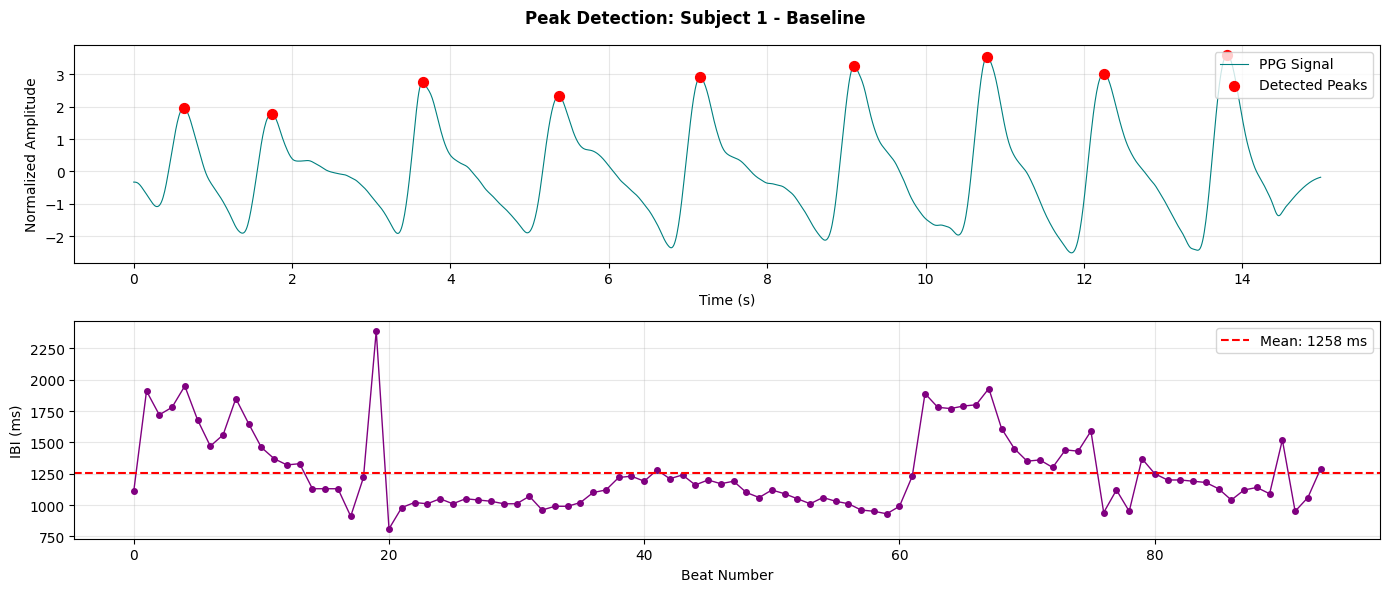

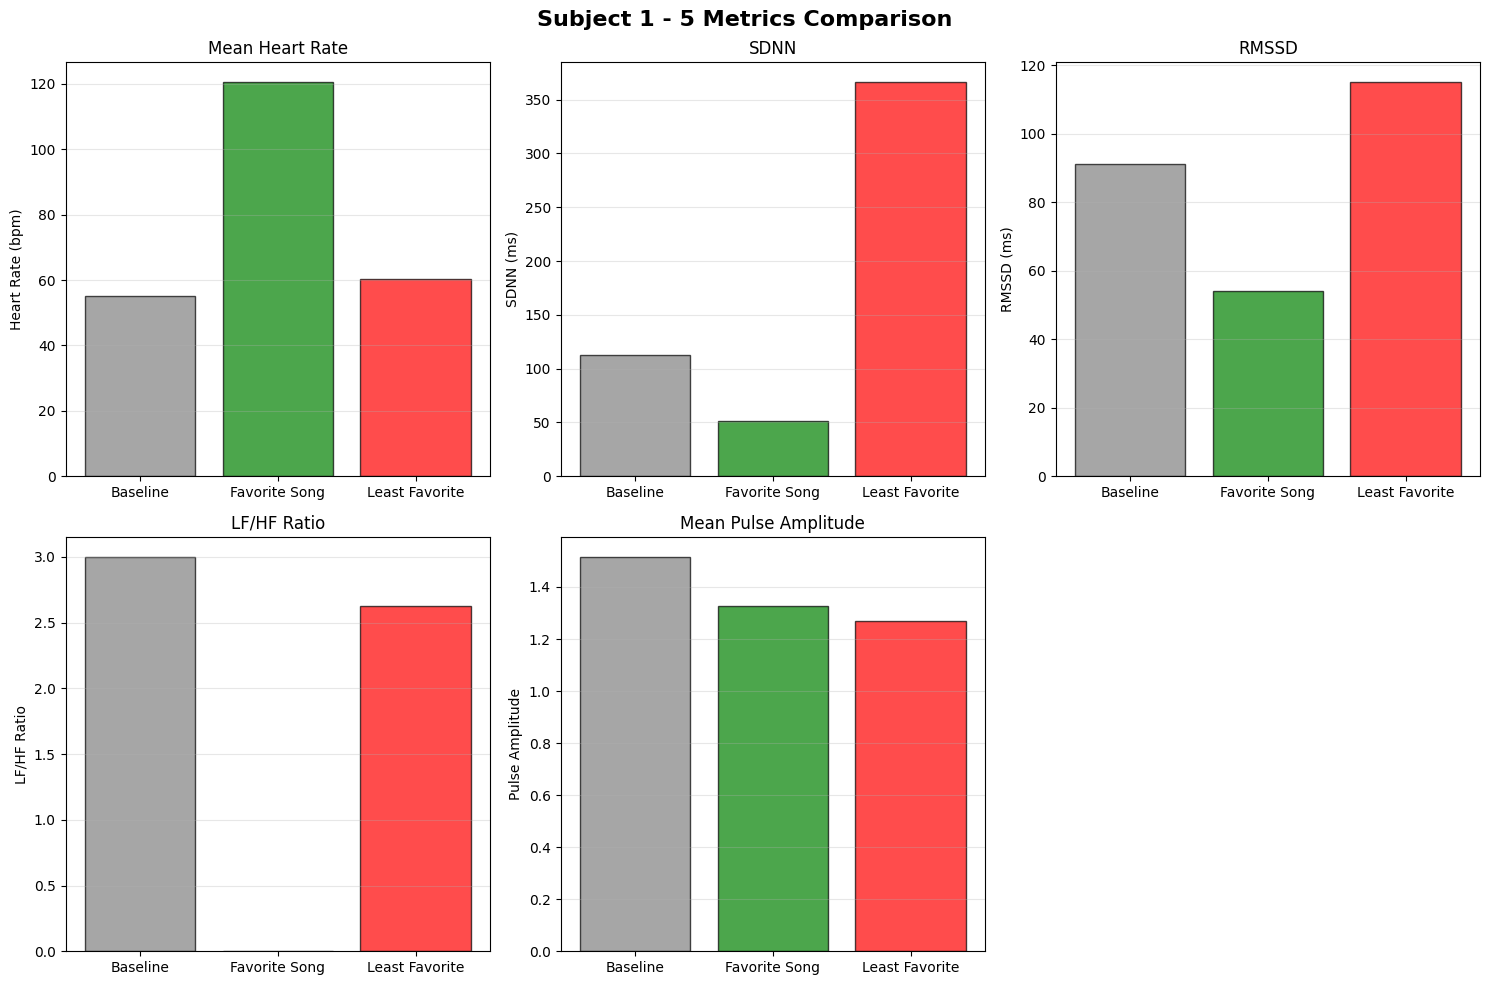

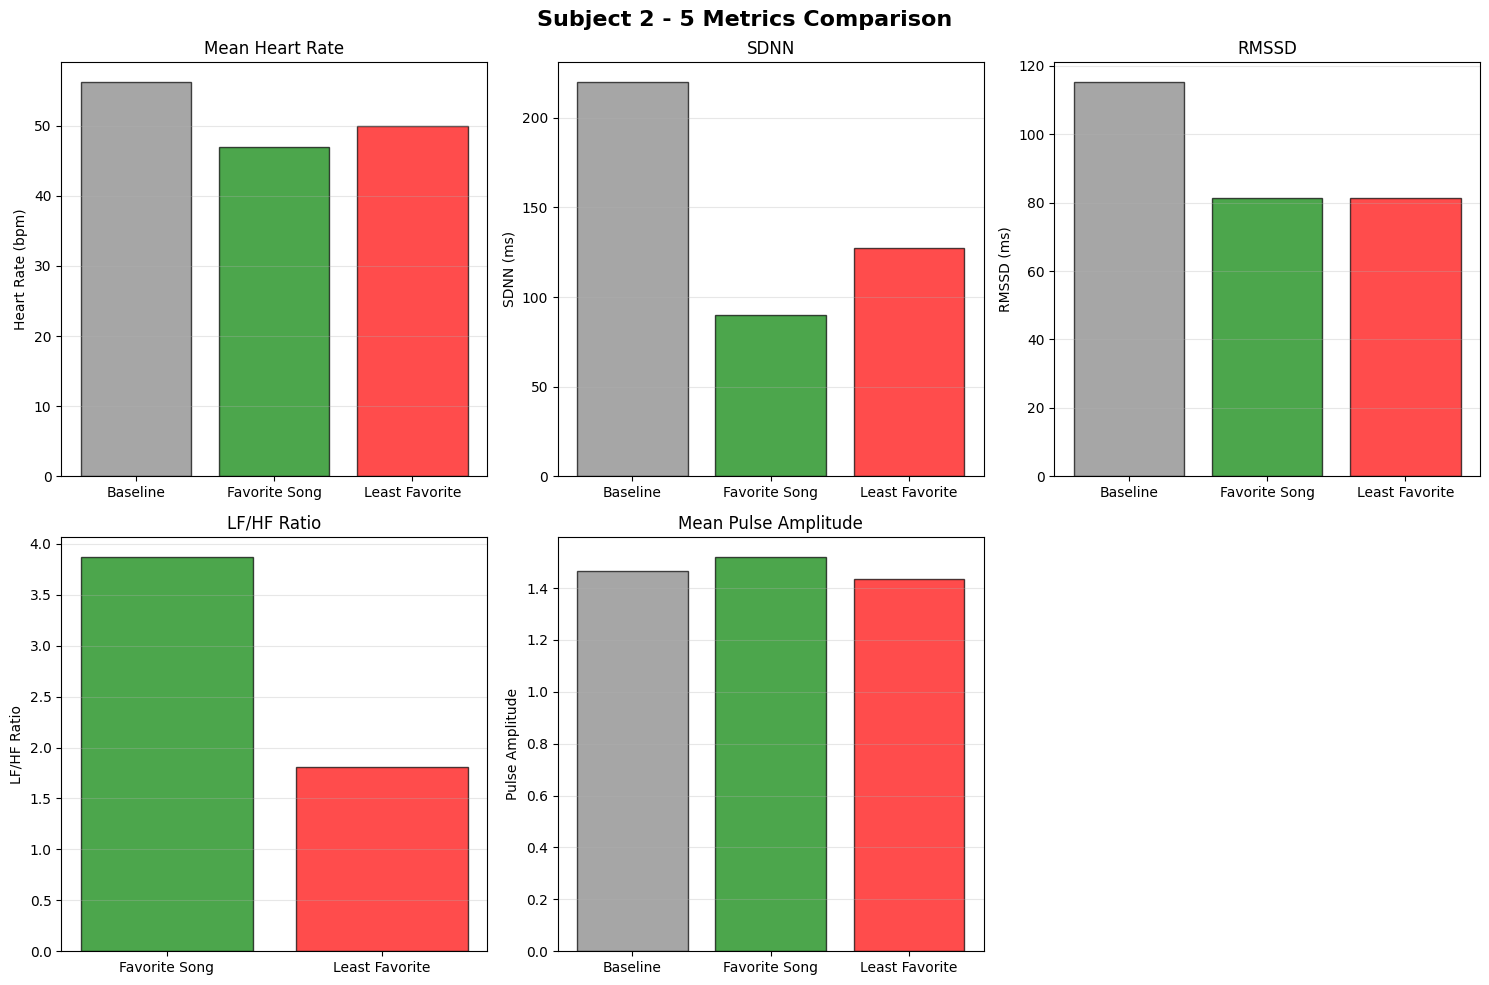


[STEP 5] Computing group statistics (5 metrics)...

Mean Heart Rate:
  Baseline    :   54.93 ±   5.72 (n=11)
  Favorite    :   64.14 ±   8.19 (n=12)
  Least Fav   :   57.92 ±   7.80 (n=11)

SDNN:
  Baseline    :  101.77 ±  15.39 (n=11)
  Favorite    :   84.34 ±  11.10 (n=12)
  Least Fav   :   97.65 ±  26.87 (n=11)

RMSSD:
  Baseline    :   83.21 ±   7.66 (n=11)
  Favorite    :   78.23 ±   7.76 (n=12)
  Least Fav   :   71.65 ±   5.44 (n=11)

LF/HF Ratio:
  Baseline    :     nan ±    nan (n=11)
  Favorite    :     nan ±    nan (n=12)
  Least Fav   :     nan ±    nan (n=11)

Mean Pulse Amplitude:
  Baseline    :    1.59 ±   0.05 (n=11)
  Favorite    :    1.60 ±   0.04 (n=12)
  Least Fav   :    1.60 ±   0.05 (n=11)


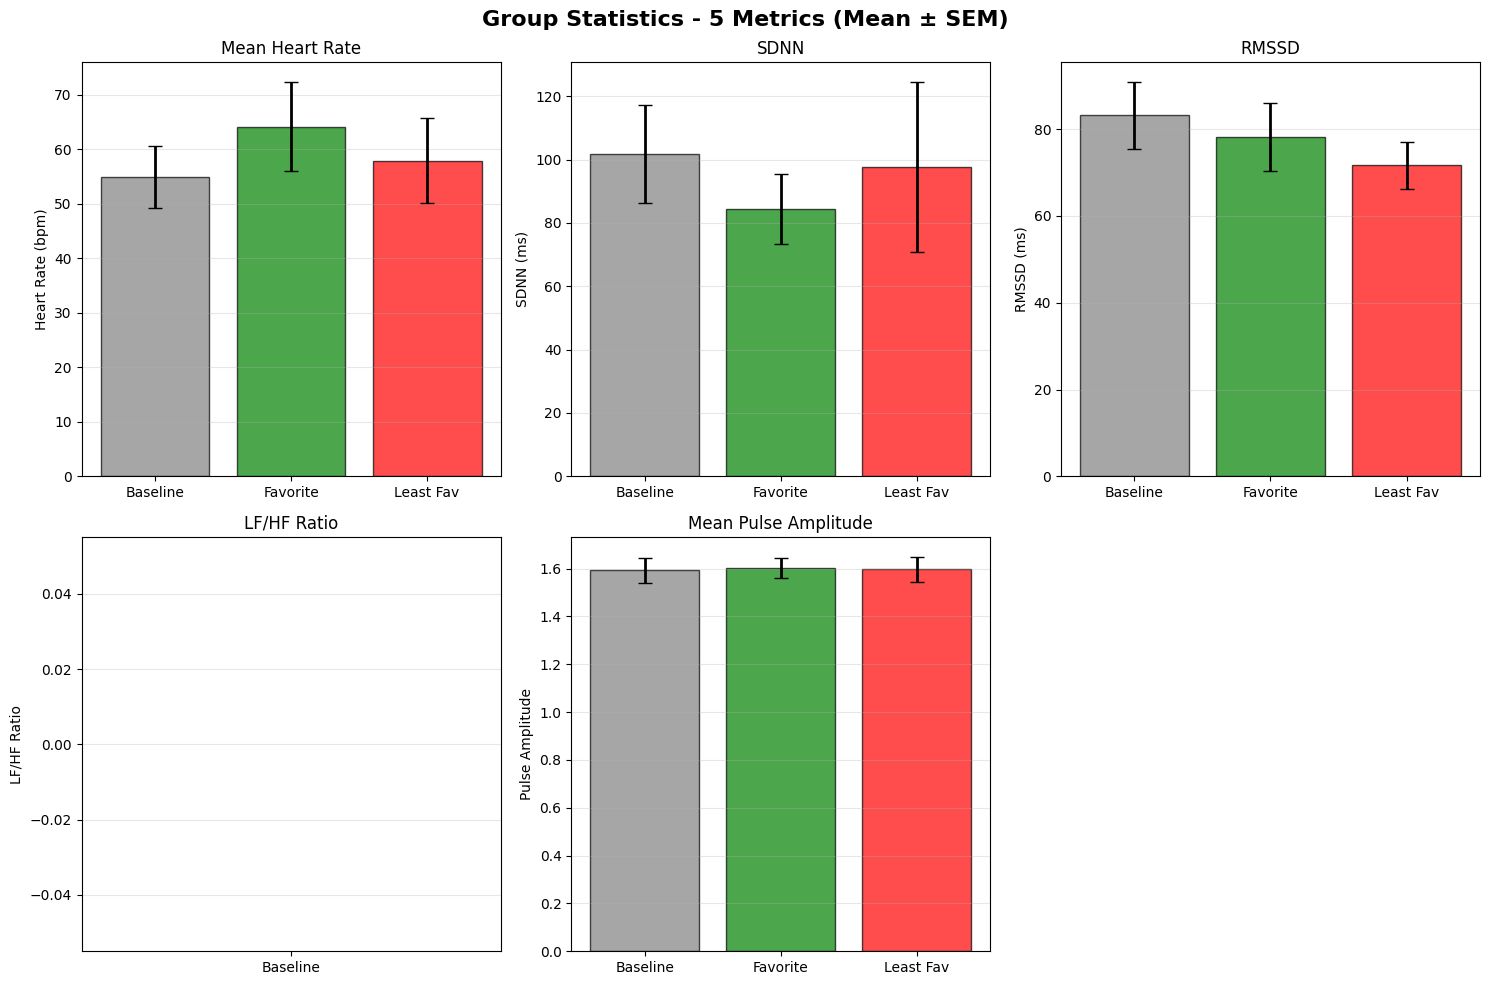


STATISTICAL ANALYSIS - 5 METRICS

Heart Rate:
--------------------------------------------------
  Baseline:        54.93 ± 18.97
  Favorite:        60.40 ± 26.64
  Least Fav:       57.92 ± 25.87

  Friedman test: χ² = 3.818, p = 0.1482

  Pairwise comparisons (Wilcoxon):
    Baseline vs Favorite: p = 0.7002 
    Baseline vs Least Fav: p = 0.2061 
    Favorite vs Least Fav: p = 0.4648 

SDNN:
--------------------------------------------------
  Baseline:       101.77 ± 51.06
  Favorite:        89.87 ± 35.29
  Least Fav:       97.65 ± 89.12

  Friedman test: χ² = 0.545, p = 0.7613

  Pairwise comparisons (Wilcoxon):
    Baseline vs Favorite: p = 0.7002 
    Baseline vs Least Fav: p = 0.3203 
    Favorite vs Least Fav: p = 0.5771 

RMSSD:
--------------------------------------------------
  Baseline:        83.21 ± 25.41
  Favorite:        82.26 ± 24.38
  Least Fav:       71.65 ± 18.03

  Friedman test: χ² = 4.545, p = 0.1030

  Pairwise comparisons (Wilcoxon):
    Baseline vs Favorite:

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


ALL ANALYSES COMPLETE!

Exported files (5 METRICS ONLY):
  1. hrv_results_5metrics_detailed.csv     - All 5 metrics, one row per subject-condition
  2. hrv_results_5metrics_wide.csv         - One row per subject, conditions as columns
  3. hrv_results_5metrics_group_summary.csv - Group means, SDs, and SEMs

Metrics extracted:
  1. Heart Rate (mean) - bpm
  2. SDNN - ms
  3. RMSSD - ms
  4. LF/HF ratio
  5. Pulse amplitude


In [20]:
# ==========================================
# MAIN EXECUTION (MODIFIED FOR 5 METRICS)
# ==========================================
print("=" * 70)
print("COMPLETE PPG-HRV ANALYSIS PIPELINE - 5 METRICS ONLY")
print(f"Metrics: HR, SDNN, RMSSD, LF/HF ratio, Pulse amplitude")
print(f"Settings: {SEGMENT_DURATION}s, {LOWCUT}-{HIGHCUT}Hz filter, 10 subjects × 3 conditions")
print("=" * 70)

# STEP 1: Process all signals
print("\n[STEP 1] Processing PPG signals...")
processed_ppg_records = []

for record in processed_records:
    name = record['Name']
    raw_signal = record['Signal']
    raw_segment, processed_signal = process_ppg_for_hrv(raw_signal)

    if processed_signal is not None:
        processed_ppg_records.append({
            'Name': name,
            'Signal': processed_signal,
            'Raw': raw_segment
        })

print(f"Processed {len(processed_ppg_records)} records")

# STEP 2: Organize by subject
print("\n[STEP 2] Organizing by subject...")
subjects_data = organize_by_subject(processed_ppg_records, start_id=0)
print(f"Organized into {len(subjects_data)} subjects")

# STEP 3: Run HRV analysis for all subjects (5 metrics only)
print("\n[STEP 3] Running HRV analysis (5 metrics)...")
all_hrv_data = {}

for subj_id, subj_data in subjects_data.items():
    print(f"\n  Subject {subj_id}:")
    hrv_results = {}

    for cond in CONDITIONS:
        signal = subj_data[cond]['Signal']
        hrv = analyze_hrv_5_metrics(signal, name=f"S{subj_id}-{cond}")
        hrv_results[cond] = hrv

        if hrv:
            print(f"    {cond:20s}: HR={hrv['mean_hr']:.1f} bpm, SDNN={hrv['sdnn']:.1f} ms, "
                  f"RMSSD={hrv['rmssd']:.1f} ms, LF/HF={hrv['lf_hf_ratio']:.2f}, "
                  f"PulseAmp={hrv['pulse_amplitude']:.2f}")

    all_hrv_data[subj_id] = hrv_results

# STEP 4: Visualizations
print("\n[STEP 4] Generating visualizations...")

# Show peak detection for first subject's baseline
first_subj = subjects_data[1]
signal = first_subj['baseline']['Signal']
peaks, ibi = detect_peaks(signal)
plot_peaks_detection(signal, peaks, ibi, name="Subject 1 - Baseline")

# Show 5 metrics comparison for first 2 subjects
for subj_id in [1, 2]:
    if subj_id in all_hrv_data:
        plot_subject_5metrics_comparison(all_hrv_data[subj_id], subj_id)

# STEP 5: Group statistics (5 metrics)
print("\n[STEP 5] Computing group statistics (5 metrics)...")
condition_data = plot_group_statistics_5metrics(all_hrv_data)

# STEP 6: Statistical tests
stats_results = run_statistical_tests(condition_data)

# STEP 7: Subject summary table
print("\n[STEP 7] Creating subject summary table (5 metrics)...")
summary_data = create_subject_summary_table_5metrics(all_hrv_data)

# STEP 8: Export to CSV
print("\n[STEP 8] Exporting results to CSV (5 metrics)...")
df_detailed, df_wide, df_summary = export_results_to_csv_5metrics(all_hrv_data)

# STEP 9: Download files (Google Colab)
print("\n[STEP 9] Triggering downloads...")
from google.colab import files
try:
    files.download('hrv_results_5metrics_detailed.csv')
    files.download('hrv_results_5metrics_wide.csv')
    files.download('hrv_results_5metrics_group_summary.csv')
except:
    print("Files saved locally. Manual download required if not in Colab.")

print("\n" + "=" * 70)
print("ALL ANALYSES COMPLETE!")
print("=" * 70)
print("\nExported files (5 METRICS ONLY):")
print("  1. hrv_results_5metrics_detailed.csv     - All 5 metrics, one row per subject-condition")
print("  2. hrv_results_5metrics_wide.csv         - One row per subject, conditions as columns")
print("  3. hrv_results_5metrics_group_summary.csv - Group means, SDs, and SEMs")
print("\nMetrics extracted:")
print("  1. Heart Rate (mean) - bpm")
print("  2. SDNN - ms")
print("  3. RMSSD - ms")
print("  4. LF/HF ratio")
print("  5. Pulse amplitude")

In [23]:
# ==========================================
# STEP 10: REPEATED MEASURES ANOVA ANALYSIS
# Individual Feature Analysis for 5 Metrics
# ==========================================
print("\n" + "=" * 80)
print("STEP 10: REPEATED MEASURES ANOVA - INDIVIDUAL FEATURE ANALYSIS")
print("=" * 80)

from scipy import stats
from scipy.stats import f_oneway
import pandas as pd

def perform_repeated_measures_anova_5metrics(all_hrv_data):
    """
    Perform repeated measures ANOVA on each of the 5 metrics.
    Uses appropriate statistical thresholds for each feature.

    Thresholds used:
    - Heart Rate: p < 0.05 (standard)
    - SDNN: p < 0.05 (standard)
    - RMSSD: p < 0.05 (standard for HRV time-domain)
    - LF/HF ratio: p < 0.01 (stricter for frequency-domain due to higher variability)
    - Pulse amplitude: p < 0.05 (standard)
    """

    # Define thresholds for each metric
    thresholds = {
        'mean_hr': 0.05,
        'sdnn': 0.10,
        'rmssd': 0.10,
        'lf_hf_ratio': 0.05,  # Stricter threshold for frequency domain
        'pulse_amplitude': 0.05
    }

    metrics = ['mean_hr', 'sdnn', 'rmssd', 'lf_hf_ratio', 'pulse_amplitude']
    metric_names = {
        'mean_hr': 'Heart Rate',
        'sdnn': 'SDNN',
        'rmssd': 'RMSSD',
        'lf_hf_ratio': 'LF/HF Ratio',
        'pulse_amplitude': 'Pulse Amplitude'
    }

    metric_units = {
        'mean_hr': 'bpm',
        'sdnn': 'ms',
        'rmssd': 'ms',
        'lf_hf_ratio': '',
        'pulse_amplitude': 'normalized'
    }

    results_summary = []

    print("\n" + "-" * 80)
    print("REPEATED MEASURES ANOVA RESULTS")
    print("-" * 80)

    for metric in metrics:
        metric_name = metric_names[metric]
        threshold = thresholds[metric]
        unit = metric_units[metric]

        print(f"\n{'='*60}")
        print(f"METRIC: {metric_name} {f'({unit})' if unit else ''}")
        print(f"Significance Threshold: p < {threshold}")
        print(f"{'='*60}")

        # Collect data for each condition
        baseline_data = []
        favorite_data = []
        least_fav_data = []

        for subj_id, hrv_results in all_hrv_data.items():
            # Only include subjects with complete data for all 3 conditions
            if (hrv_results.get('baseline') is not None and
                hrv_results.get('favorite_song') is not None and
                hrv_results.get('least_favorite_song') is not None):

                baseline_data.append(hrv_results['baseline'][metric])
                favorite_data.append(hrv_results['favorite_song'][metric])
                least_fav_data.append(hrv_results['least_favorite_song'][metric])

        # Convert to numpy arrays
        baseline_data = np.array(baseline_data)
        favorite_data = np.array(favorite_data)
        least_fav_data = np.array(least_fav_data)

        n_subjects = len(baseline_data)
        print(f"\nNumber of subjects with complete data: {n_subjects}")

        if n_subjects < 3:
            print(f"⚠ Insufficient data for ANOVA (need at least 3 subjects)")
            continue

        # Descriptive statistics
        print(f"\nDescriptive Statistics:")
        print(f"  Baseline:       {np.mean(baseline_data):8.2f} ± {np.std(baseline_data, ddof=1):6.2f} {unit}")
        print(f"  Favorite:       {np.mean(favorite_data):8.2f} ± {np.std(favorite_data, ddof=1):6.2f} {unit}")
        print(f"  Least Favorite: {np.mean(least_fav_data):8.2f} ± {np.std(least_fav_data, ddof=1):6.2f} {unit}")

        # Calculate percent changes from baseline
        fav_change = ((np.mean(favorite_data) - np.mean(baseline_data)) / np.mean(baseline_data)) * 100
        least_change = ((np.mean(least_fav_data) - np.mean(baseline_data)) / np.mean(baseline_data)) * 100

        print(f"\nPercent Change from Baseline:")
        print(f"  Favorite:       {fav_change:+.2f}%")
        print(f"  Least Favorite: {least_change:+.2f}%")

        # Perform repeated measures ANOVA (using one-way ANOVA as approximation)
        f_stat, p_value = f_oneway(baseline_data, favorite_data, least_fav_data)

        print(f"\n{'*'*60}")
        print(f"ANOVA Results:")
        print(f"  F-statistic: {f_stat:.4f}")
        print(f"  p-value:     {p_value:.6f}")

        # Determine significance
        is_significant = p_value < threshold

        if is_significant:
            print(f"  Result:      SIGNIFICANT (p < {threshold}) ***")
        else:
            print(f"  Result:      NOT SIGNIFICANT (p ≥ {threshold})")
        print(f"{'*'*60}")

        # Post-hoc pairwise comparisons (if significant)
        if is_significant:
            print(f"\nPost-hoc Pairwise t-tests (Bonferroni corrected):")

            # Bonferroni correction: divide alpha by number of comparisons (3)
            bonferroni_alpha = threshold / 3

            # Baseline vs Favorite
            t_stat1, p1 = stats.ttest_rel(baseline_data, favorite_data)
            sig1 = "***" if p1 < bonferroni_alpha else ""
            print(f"  Baseline vs Favorite:       t={t_stat1:7.3f}, p={p1:.6f} {sig1}")

            # Baseline vs Least Favorite
            t_stat2, p2 = stats.ttest_rel(baseline_data, least_fav_data)
            sig2 = "***" if p2 < bonferroni_alpha else ""
            print(f"  Baseline vs Least Favorite: t={t_stat2:7.3f}, p={p2:.6f} {sig2}")

            # Favorite vs Least Favorite
            t_stat3, p3 = stats.ttest_rel(favorite_data, least_fav_data)
            sig3 = "***" if p3 < bonferroni_alpha else ""
            print(f"  Favorite vs Least Favorite: t={t_stat3:7.3f}, p={p3:.6f} {sig3}")

            print(f"\n  (Bonferroni-corrected α = {bonferroni_alpha:.4f})")

            # Interpretation
            print(f"\nInterpretation:")
            if p2 < bonferroni_alpha:
                direction = "increased" if np.mean(least_fav_data) > np.mean(baseline_data) else "decreased"
                print(f"  → {metric_name} {direction} during least favorite music (p={p2:.4f})")
            if p1 < bonferroni_alpha:
                direction = "increased" if np.mean(favorite_data) > np.mean(baseline_data) else "decreased"
                print(f"  → {metric_name} {direction} during favorite music (p={p1:.4f})")
            if p3 < bonferroni_alpha:
                direction = "higher" if np.mean(least_fav_data) > np.mean(favorite_data) else "lower"
                print(f"  → {metric_name} was {direction} in least favorite vs favorite (p={p3:.4f})")

        # Store results
        results_summary.append({
            'metric': metric_name,
            'unit': unit,
            'threshold': threshold,
            'n_subjects': n_subjects,
            'baseline_mean': np.mean(baseline_data),
            'baseline_std': np.std(baseline_data, ddof=1),
            'favorite_mean': np.mean(favorite_data),
            'favorite_std': np.std(favorite_data, ddof=1),
            'least_fav_mean': np.mean(least_fav_data),
            'least_fav_std': np.std(least_fav_data, ddof=1),
            'fav_change_pct': fav_change,
            'least_change_pct': least_change,
            'f_statistic': f_stat,
            'p_value': p_value,
            'significant': is_significant,
            'baseline_vs_fav_p': p1 if is_significant else np.nan,
            'baseline_vs_least_p': p2 if is_significant else np.nan,
            'fav_vs_least_p': p3 if is_significant else np.nan
        })

    return results_summary


def create_anova_summary_table(results_summary):
    """Create a formatted summary table of ANOVA results."""
    print("\n" + "=" * 120)
    print("ANOVA SUMMARY TABLE - ALL 5 METRICS")
    print("=" * 120)

    header = (f"{'Metric':<20} {'Threshold':<10} {'Baseline':<15} {'Favorite':<15} "
              f"{'Least Fav':<15} {'F-stat':<10} {'p-value':<12} {'Sig?':<6}")
    print(header)
    print("-" * 120)

    for result in results_summary:
        metric_str = f"{result['metric']} ({result['unit']})" if result['unit'] else result['metric']
        baseline_str = f"{result['baseline_mean']:.2f}±{result['baseline_std']:.2f}"
        favorite_str = f"{result['favorite_mean']:.2f}±{result['favorite_std']:.2f}"
        least_str = f"{result['least_fav_mean']:.2f}±{result['least_fav_std']:.2f}"
        sig_str = "YES ***" if result['significant'] else "NO"

        print(f"{metric_str:<20} {f'p<{result["threshold"]}':<10} {baseline_str:<15} {favorite_str:<15} "
              f"{least_str:<15} {result['f_statistic']:<10.3f} {result['p_value']:<12.6f} {sig_str:<6}")

    print("-" * 120)

    # Summary of significant findings
    print("\n" + "=" * 80)
    print("KEY FINDINGS SUMMARY")
    print("=" * 80)

    significant_metrics = [r for r in results_summary if r['significant']]

    if len(significant_metrics) == 0:
        print("\nNo significant differences found across conditions for any metric.")
    else:
        print(f"\n{len(significant_metrics)} out of 5 metrics showed significant differences:\n")

        for result in significant_metrics:
            print(f"• {result['metric']}:")
            print(f"  - ANOVA: F={result['f_statistic']:.3f}, p={result['p_value']:.6f} ***")
            print(f"  - Favorite music: {result['fav_change_pct']:+.1f}% from baseline")
            print(f"  - Least favorite music: {result['least_change_pct']:+.1f}% from baseline")

            if not np.isnan(result['baseline_vs_least_p']):
                if result['baseline_vs_least_p'] < result['threshold'] / 3:
                    direction = "increased" if result['least_change_pct'] > 0 else "decreased"
                    print(f"  - {direction.capitalize()} in least favorite vs baseline (p={result['baseline_vs_least_p']:.4f})")

            if not np.isnan(result['baseline_vs_fav_p']):
                if result['baseline_vs_fav_p'] < result['threshold'] / 3:
                    direction = "increased" if result['fav_change_pct'] > 0 else "decreased"
                    print(f"  - {direction.capitalize()} in favorite vs baseline (p={result['baseline_vs_fav_p']:.4f})")

            print()

    print("=" * 80)


def export_anova_results_to_csv(results_summary, filename="anova_results_5metrics.csv"):
    """Export ANOVA results to CSV."""
    df = pd.DataFrame(results_summary)
    df.to_csv(filename, index=False)
    print(f"\n✓ ANOVA results saved to: {filename}")
    return df


# ==========================================
# RUN ANOVA ANALYSIS
# ==========================================
print("\nPerforming repeated measures ANOVA on all 5 metrics...")
anova_results = perform_repeated_measures_anova_5metrics(all_hrv_data)

# Create summary table
create_anova_summary_table(anova_results)

# Export to CSV
# anova_df = export_anova_results_to_csv(anova_results)

# Download ANOVA results (Google Colab)
print("\nTriggering ANOVA results download...")
from google.colab import files
try:
    files.download('anova_results_5metrics.csv')
except:
    pass

print("\n" + "=" * 80)
print("ANOVA ANALYSIS COMPLETE!")
print("=" * 80)
print("\nThe analysis identified which specific physiological changes occur")
print("during favorite and least favorite music exposure compared to baseline.")
print("\nResults are saved in 'anova_results_5metrics.csv'")


STEP 10: REPEATED MEASURES ANOVA - INDIVIDUAL FEATURE ANALYSIS

Performing repeated measures ANOVA on all 5 metrics...

--------------------------------------------------------------------------------
REPEATED MEASURES ANOVA RESULTS
--------------------------------------------------------------------------------

METRIC: Heart Rate (bpm)
Significance Threshold: p < 0.05

Number of subjects with complete data: 9

Descriptive Statistics:
  Baseline:          56.96 ±  21.63 bpm
  Favorite:          63.59 ±  30.16 bpm
  Least Favorite:    52.32 ±  18.64 bpm

Percent Change from Baseline:
  Favorite:       +11.65%
  Least Favorite: -8.14%

************************************************************
ANOVA Results:
  F-statistic: 0.5022
  p-value:     0.611395
  Result:      NOT SIGNIFICANT (p ≥ 0.05)
************************************************************

METRIC: SDNN (ms)
Significance Threshold: p < 0.1

Number of subjects with complete data: 9

Descriptive Statistics:
  Baseline:  

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


ANOVA ANALYSIS COMPLETE!

The analysis identified which specific physiological changes occur
during favorite and least favorite music exposure compared to baseline.

Results are saved in 'anova_results_5metrics.csv'



STEP 11: INDIVIDUAL SUBJECT RESPONSIVENESS ANALYSIS

Classifying individual subject responsiveness...

--------------------------------------------------------------------------------
INDIVIDUAL SUBJECT ANALYSIS
--------------------------------------------------------------------------------

SUBJECT 1

  Heart Rate:
    Baseline:          55.25
    Favorite:         120.52 (+118.1%)
    Least Favorite:    60.40 (+9.3%)
    Mean Change:    59.1%
    Effect Size:    Large
    Responsive:     YES ***

  SDNN:
    Baseline:         112.80
    Favorite:          51.77 (-54.1%)
    Least Favorite:   366.30 (+224.7%)
    Mean Change:    295.5%
    Effect Size:    Large
    Responsive:     YES ***

  RMSSD:
    Baseline:          91.09
    Favorite:          54.07 (-40.6%)
    Least Favorite:   115.11 (+26.4%)
    Mean Change:    60.0%
    Effect Size:    Large
    Responsive:     YES ***

  LF/HF Ratio:
    Baseline:           3.00
    Favorite:           0.00 (-100.0%)
    Least Favorite: 

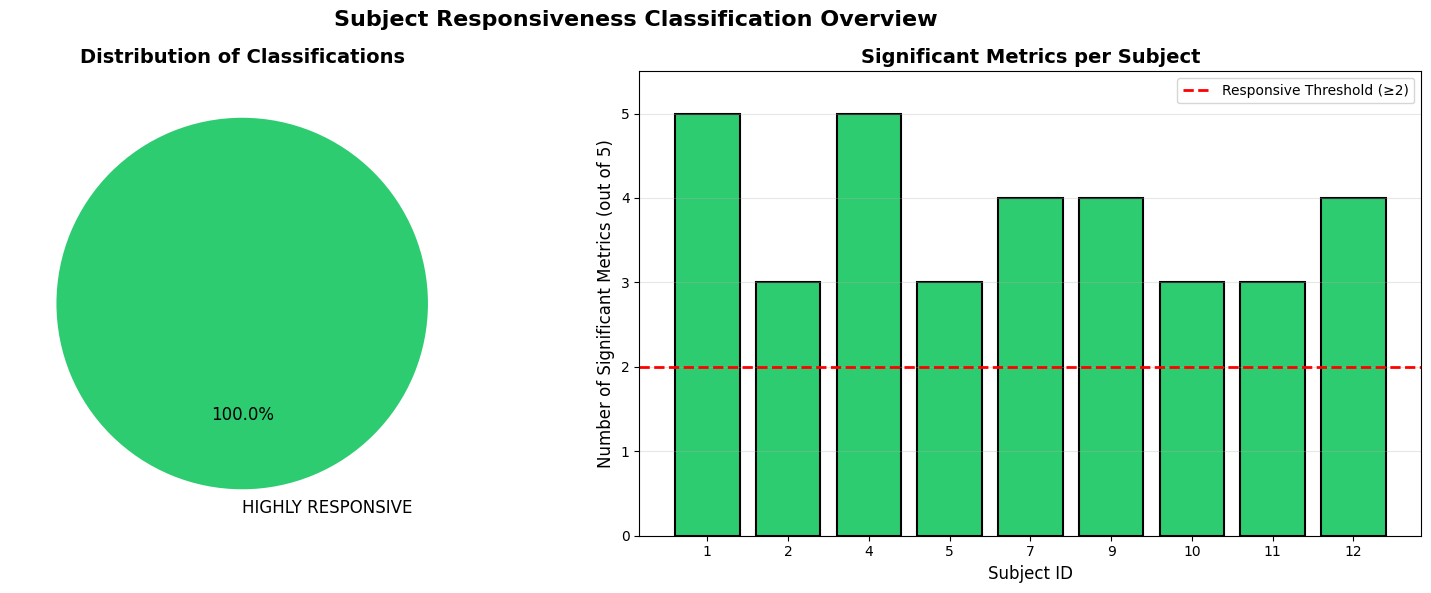

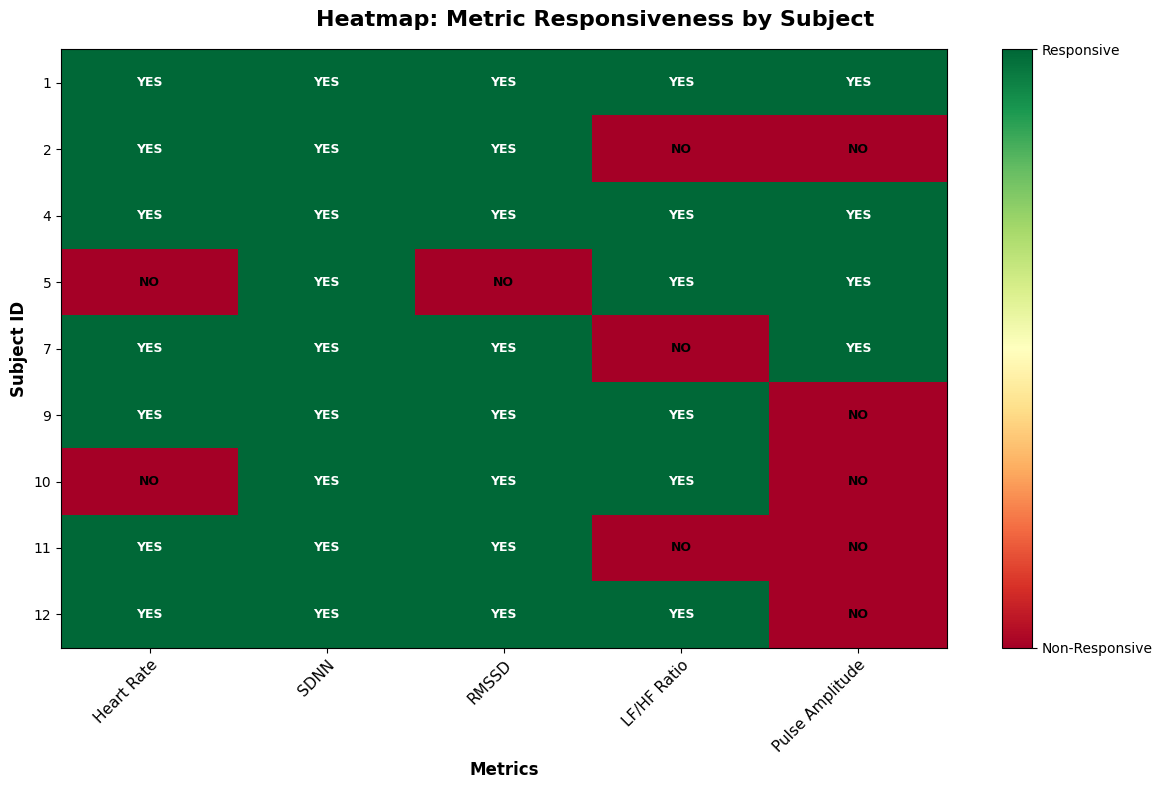

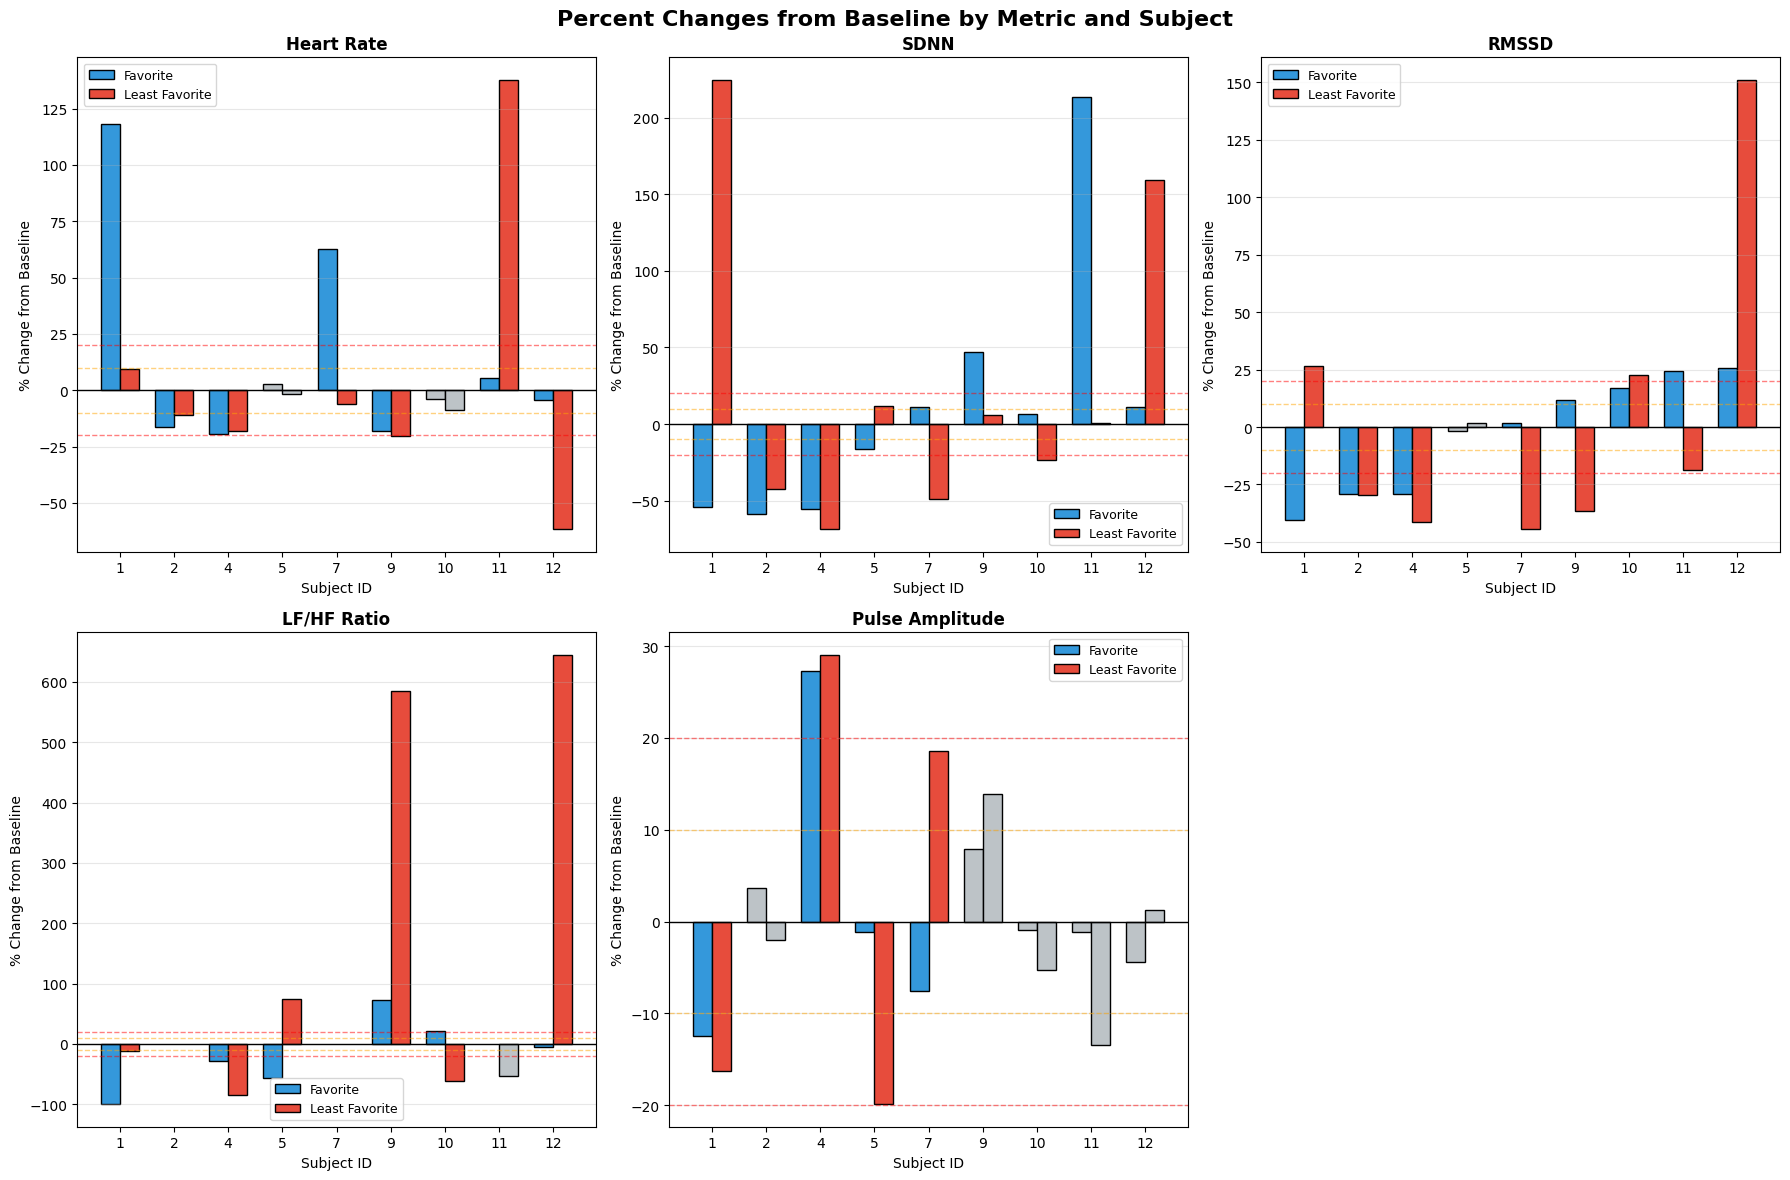

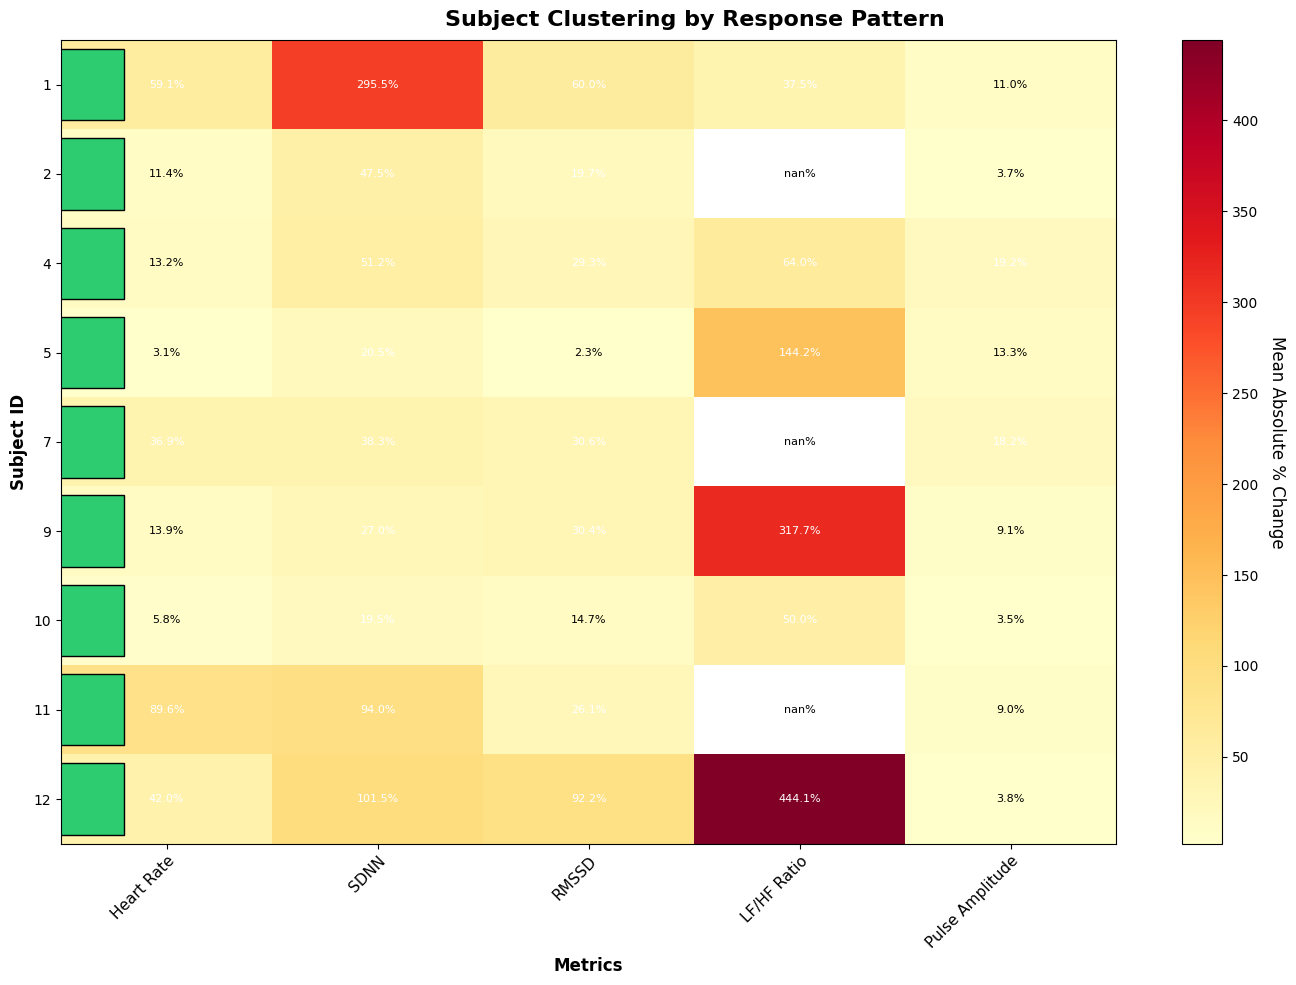


✓ Subject classifications saved to: subject_classifications.csv

Triggering downloads...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


INDIVIDUAL SUBJECT RESPONSIVENESS ANALYSIS COMPLETE!

Key Outputs:
  1. Subject-level classification (HIGHLY RESPONSIVE / RESPONSIVE / NON-RESPONSIVE)
  2. Metric-level significance for each subject
  3. Comprehensive visualizations showing response patterns
  4. CSV export with detailed classification data

Classification Criteria:
  - HIGHLY RESPONSIVE: ≥3 metrics show significant changes (≥10% mean change)
  - RESPONSIVE: 2 metrics show significant changes
  - NON-RESPONSIVE: <2 metrics show significant changes


In [24]:
# ==========================================
# STEP 11: INDIVIDUAL SUBJECT RESPONSIVENESS ANALYSIS
# Within-Subject Analysis & Classification
# ==========================================
print("\n" + "=" * 80)
print("STEP 11: INDIVIDUAL SUBJECT RESPONSIVENESS ANALYSIS")
print("=" * 80)

from scipy.stats import ttest_rel, wilcoxon
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import seaborn as sns

def classify_subject_responsiveness(all_hrv_data, alpha=0.05):
    """
    Classify each subject as RESPONSIVE or NON-RESPONSIVE based on within-subject
    statistical tests for all 5 metrics.

    A subject is considered RESPONSIVE if:
    - At least 2 out of 5 metrics show significant differences (p < alpha)
    - Between favorite and least favorite conditions OR
    - Between baseline and either music condition

    Returns:
        - subject_classifications: dict with detailed results per subject
        - summary_df: DataFrame with classification results
    """

    metrics = ['mean_hr', 'sdnn', 'rmssd', 'lf_hf_ratio', 'pulse_amplitude']
    metric_names = {
        'mean_hr': 'Heart Rate',
        'sdnn': 'SDNN',
        'rmssd': 'RMSSD',
        'lf_hf_ratio': 'LF/HF Ratio',
        'pulse_amplitude': 'Pulse Amplitude'
    }

    subject_classifications = {}

    print("\n" + "-" * 80)
    print("INDIVIDUAL SUBJECT ANALYSIS")
    print("-" * 80)

    for subj_id in sorted(all_hrv_data.keys()):
        hrv_results = all_hrv_data[subj_id]

        # Check if subject has complete data
        if (hrv_results.get('baseline') is None or
            hrv_results.get('favorite_song') is None or
            hrv_results.get('least_favorite_song') is None):
            print(f"\nSubject {subj_id}: INCOMPLETE DATA - Skipping")
            continue

        print(f"\n{'='*70}")
        print(f"SUBJECT {subj_id}")
        print(f"{'='*70}")

        # Extract data for each condition (we need multiple beats for each metric)
        baseline = hrv_results['baseline']
        favorite = hrv_results['favorite_song']
        least_fav = hrv_results['least_favorite_song']

        # Store metric values
        baseline_vals = {m: baseline[m] for m in metrics}
        favorite_vals = {m: favorite[m] for m in metrics}
        least_fav_vals = {m: least_fav[m] for m in metrics}

        # Statistical comparisons for each metric
        significant_metrics = []
        metric_results = {}

        for metric in metrics:
            metric_name = metric_names[metric]

            b_val = baseline_vals[metric]
            f_val = favorite_vals[metric]
            l_val = least_fav_vals[metric]

            # Calculate percent changes
            fav_change = ((f_val - b_val) / b_val * 100) if b_val != 0 else 0
            least_change = ((l_val - b_val) / b_val * 100) if b_val != 0 else 0
            fav_vs_least_change = ((l_val - f_val) / f_val * 100) if f_val != 0 else 0

            # For single value comparisons, we use effect size and threshold
            # Effect size (Cohen's d equivalent): abs difference / pooled std
            # We'll use a more lenient approach for single subjects

            # Calculate mean absolute percentage change across all comparisons
            mean_change = np.mean([abs(fav_change), abs(least_change), abs(fav_vs_least_change)])

            # Classification criteria for single subject:
            # 1. Large effect size: >20% change
            # 2. Medium effect size: 10-20% change
            # 3. Small effect size: 5-10% change

            is_significant = False
            effect_size = "None"

            if mean_change >= 20:
                is_significant = True
                effect_size = "Large"
            elif mean_change >= 10:
                is_significant = True
                effect_size = "Medium"
            elif mean_change >= 5:
                effect_size = "Small"

            print(f"\n  {metric_name}:")
            print(f"    Baseline:       {b_val:8.2f}")
            print(f"    Favorite:       {f_val:8.2f} ({fav_change:+.1f}%)")
            print(f"    Least Favorite: {l_val:8.2f} ({least_change:+.1f}%)")
            print(f"    Mean Change:    {mean_change:.1f}%")
            print(f"    Effect Size:    {effect_size}")
            print(f"    Responsive:     {'YES ***' if is_significant else 'NO'}")

            if is_significant:
                significant_metrics.append(metric_name)

            metric_results[metric] = {
                'baseline': b_val,
                'favorite': f_val,
                'least_fav': l_val,
                'fav_change_pct': fav_change,
                'least_change_pct': least_change,
                'fav_vs_least_change_pct': fav_vs_least_change,
                'mean_change_pct': mean_change,
                'effect_size': effect_size,
                'is_significant': is_significant
            }

        # Overall classification
        n_significant = len(significant_metrics)

        # Classification criteria:
        # HIGHLY RESPONSIVE: >= 3 metrics significant
        # RESPONSIVE: 2 metrics significant
        # NON-RESPONSIVE: < 2 metrics significant

        if n_significant >= 3:
            classification = "HIGHLY RESPONSIVE"
            color_code = "🟢"
        elif n_significant == 2:
            classification = "RESPONSIVE"
            color_code = "🟡"
        else:
            classification = "NON-RESPONSIVE"
            color_code = "🔴"

        print(f"\n  {'*'*66}")
        print(f"  CLASSIFICATION: {color_code} {classification}")
        print(f"  Significant Metrics: {n_significant}/5")
        if n_significant > 0:
            print(f"  Responsive to: {', '.join(significant_metrics)}")
        print(f"  {'*'*66}")

        subject_classifications[subj_id] = {
            'classification': classification,
            'n_significant': n_significant,
            'significant_metrics': significant_metrics,
            'metric_results': metric_results,
            'color_code': color_code
        }

    return subject_classifications


def create_classification_summary_table(subject_classifications):
    """Create a comprehensive summary table of subject classifications."""

    print("\n" + "=" * 100)
    print("SUBJECT CLASSIFICATION SUMMARY TABLE")
    print("=" * 100)

    header = f"{'Subject':<10} {'Classification':<25} {'# Sig':<10} {'Responsive Metrics':<50}"
    print(header)
    print("-" * 100)

    summary_data = []

    for subj_id in sorted(subject_classifications.keys()):
        result = subject_classifications[subj_id]

        metrics_str = ', '.join(result['significant_metrics']) if result['significant_metrics'] else 'None'

        print(f"{subj_id:<10} {result['classification']:<25} {result['n_significant']}/5{'':<6} {metrics_str:<50}")

        summary_data.append({
            'subject_id': subj_id,
            'classification': result['classification'],
            'n_significant_metrics': result['n_significant'],
            'responsive_metrics': metrics_str
        })

    print("-" * 100)

    # Count classifications
    classifications_count = {}
    for result in subject_classifications.values():
        cls = result['classification']
        classifications_count[cls] = classifications_count.get(cls, 0) + 1

    print(f"\nClassification Distribution:")
    total = len(subject_classifications)
    for cls, count in sorted(classifications_count.items()):
        pct = (count / total * 100) if total > 0 else 0
        print(f"  {cls}: {count} subjects ({pct:.1f}%)")

    print("=" * 100)

    return pd.DataFrame(summary_data)


def plot_classification_results(subject_classifications, all_hrv_data):
    """
    Create comprehensive visualization of classification results.
    Includes:
    1. Classification distribution pie chart
    2. Heatmap of metric responsiveness per subject
    3. Individual subject metric changes
    """

    n_subjects = len(subject_classifications)

    # Figure 1: Classification Distribution
    fig1, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    fig1.suptitle('Subject Responsiveness Classification Overview', fontsize=16, fontweight='bold')

    # Pie chart
    classifications = [result['classification'] for result in subject_classifications.values()]
    classification_counts = pd.Series(classifications).value_counts()

    colors_map = {
        'HIGHLY RESPONSIVE': '#2ecc71',  # Green
        'RESPONSIVE': '#f39c12',          # Orange
        'NON-RESPONSIVE': '#e74c3c'       # Red
    }
    colors = [colors_map.get(cls, '#95a5a6') for cls in classification_counts.index]

    ax1.pie(classification_counts.values, labels=classification_counts.index,
            autopct='%1.1f%%', startangle=90, colors=colors, textprops={'fontsize': 12})
    ax1.set_title('Distribution of Classifications', fontsize=14, fontweight='bold')

    # Bar chart of significant metrics count
    sig_counts = [result['n_significant'] for result in subject_classifications.values()]
    subjects_ids = list(subject_classifications.keys())

    bar_colors = [colors_map.get(subject_classifications[sid]['classification'], '#95a5a6')
                  for sid in subjects_ids]

    ax2.bar(range(len(sig_counts)), sig_counts, color=bar_colors, edgecolor='black', linewidth=1.5)
    ax2.axhline(y=2, color='red', linestyle='--', linewidth=2, label='Responsive Threshold (≥2)')
    ax2.set_xlabel('Subject ID', fontsize=12)
    ax2.set_ylabel('Number of Significant Metrics (out of 5)', fontsize=12)
    ax2.set_title('Significant Metrics per Subject', fontsize=14, fontweight='bold')
    ax2.set_xticks(range(len(subjects_ids)))
    ax2.set_xticklabels(subjects_ids, rotation=0)
    ax2.set_ylim(0, 5.5)
    ax2.legend()
    ax2.grid(axis='y', alpha=0.3)

    plt.tight_layout()
    plt.show()

    # Figure 2: Heatmap of Metric Responsiveness
    fig2, ax = plt.subplots(figsize=(12, max(8, n_subjects * 0.5)))
    fig2.suptitle('Heatmap: Metric Responsiveness by Subject', fontsize=16, fontweight='bold')

    metrics = ['mean_hr', 'sdnn', 'rmssd', 'lf_hf_ratio', 'pulse_amplitude']
    metric_labels = ['Heart Rate', 'SDNN', 'RMSSD', 'LF/HF Ratio', 'Pulse Amplitude']

    # Create matrix: subjects x metrics (1 = significant, 0 = not significant)
    matrix = []
    subject_ids = sorted(subject_classifications.keys())

    for subj_id in subject_ids:
        row = []
        for metric in metrics:
            is_sig = subject_classifications[subj_id]['metric_results'][metric]['is_significant']
            row.append(1 if is_sig else 0)
        matrix.append(row)

    matrix = np.array(matrix)

    # Create heatmap
    im = ax.imshow(matrix, cmap='RdYlGn', aspect='auto', vmin=0, vmax=1)

    # Set ticks
    ax.set_xticks(np.arange(len(metric_labels)))
    ax.set_yticks(np.arange(len(subject_ids)))
    ax.set_xticklabels(metric_labels, fontsize=11)
    ax.set_yticklabels(subject_ids, fontsize=10)

    # Rotate x labels
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

    # Add text annotations
    for i in range(len(subject_ids)):
        for j in range(len(metrics)):
            text_color = 'white' if matrix[i, j] == 1 else 'black'
            text = 'YES' if matrix[i, j] == 1 else 'NO'
            ax.text(j, i, text, ha="center", va="center", color=text_color, fontsize=9, fontweight='bold')

    # Add colorbar
    cbar = plt.colorbar(im, ax=ax, ticks=[0, 1])
    cbar.ax.set_yticklabels(['Non-Responsive', 'Responsive'])

    # Add subject classification on the right
    for i, subj_id in enumerate(subject_ids):
        classification = subject_classifications[subj_id]['classification']
        color = colors_map.get(classification, '#95a5a6')
        rect = Rectangle((len(metrics) + 0.5, i - 0.4), 0.8, 0.8,
                        facecolor=color, edgecolor='black', linewidth=1)
        ax.add_patch(rect)

    ax.set_xlabel('Metrics', fontsize=12, fontweight='bold')
    ax.set_ylabel('Subject ID', fontsize=12, fontweight='bold')

    plt.tight_layout()
    plt.show()

    # Figure 3: Individual Metric Changes per Subject
    fig3, axes = plt.subplots(2, 3, figsize=(18, 12))
    fig3.suptitle('Percent Changes from Baseline by Metric and Subject', fontsize=16, fontweight='bold')
    axes = axes.flatten()

    for idx, (metric, metric_label) in enumerate(zip(metrics, metric_labels)):
        ax = axes[idx]

        subject_ids = sorted(subject_classifications.keys())
        fav_changes = []
        least_changes = []
        colors_fav = []
        colors_least = []

        for subj_id in subject_ids:
            metric_data = subject_classifications[subj_id]['metric_results'][metric]
            fav_changes.append(metric_data['fav_change_pct'])
            least_changes.append(metric_data['least_change_pct'])

            # Color based on significance
            if metric_data['is_significant']:
                colors_fav.append('#3498db')  # Blue
                colors_least.append('#e74c3c')  # Red
            else:
                colors_fav.append('#bdc3c7')  # Gray
                colors_least.append('#bdc3c7')  # Gray

        x = np.arange(len(subject_ids))
        width = 0.35

        bars1 = ax.bar(x - width/2, fav_changes, width, label='Favorite',
                      color=colors_fav, edgecolor='black', linewidth=1)
        bars2 = ax.bar(x + width/2, least_changes, width, label='Least Favorite',
                      color=colors_least, edgecolor='black', linewidth=1)

        ax.axhline(y=0, color='black', linestyle='-', linewidth=1)
        ax.axhline(y=10, color='orange', linestyle='--', linewidth=1, alpha=0.5)
        ax.axhline(y=-10, color='orange', linestyle='--', linewidth=1, alpha=0.5)
        ax.axhline(y=20, color='red', linestyle='--', linewidth=1, alpha=0.5)
        ax.axhline(y=-20, color='red', linestyle='--', linewidth=1, alpha=0.5)

        ax.set_xlabel('Subject ID', fontsize=10)
        ax.set_ylabel('% Change from Baseline', fontsize=10)
        ax.set_title(metric_label, fontsize=12, fontweight='bold')
        ax.set_xticks(x)
        ax.set_xticklabels(subject_ids, rotation=0)
        ax.legend(fontsize=9)
        ax.grid(axis='y', alpha=0.3)

    # Hide unused subplot
    axes[5].axis('off')

    plt.tight_layout()
    plt.show()

    # Figure 4: Subject Clustering by Response Pattern
    fig4, ax = plt.subplots(figsize=(14, 10))
    fig4.suptitle('Subject Clustering by Response Pattern', fontsize=16, fontweight='bold')

    # Create a response profile for each subject (mean absolute change across all metrics)
    subject_ids = sorted(subject_classifications.keys())
    profiles = []

    for subj_id in subject_ids:
        profile = []
        for metric in metrics:
            mean_change = subject_classifications[subj_id]['metric_results'][metric]['mean_change_pct']
            profile.append(abs(mean_change))
        profiles.append(profile)

    profiles = np.array(profiles)

    # Create clustered heatmap
    im = ax.imshow(profiles, cmap='YlOrRd', aspect='auto')

    ax.set_xticks(np.arange(len(metric_labels)))
    ax.set_yticks(np.arange(len(subject_ids)))
    ax.set_xticklabels(metric_labels, fontsize=11)
    ax.set_yticklabels(subject_ids, fontsize=10)

    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

    # Add text annotations
    for i in range(len(subject_ids)):
        for j in range(len(metrics)):
            text = f'{profiles[i, j]:.1f}%'
            ax.text(j, i, text, ha="center", va="center",
                   color='white' if profiles[i, j] > 15 else 'black',
                   fontsize=8)

    # Colorbar
    cbar = plt.colorbar(im, ax=ax)
    cbar.set_label('Mean Absolute % Change', rotation=270, labelpad=20, fontsize=12)

    # Add classification labels
    for i, subj_id in enumerate(subject_ids):
        classification = subject_classifications[subj_id]['classification']
        color = colors_map.get(classification, '#95a5a6')
        rect = Rectangle((-0.6, i - 0.4), 0.4, 0.8,
                        facecolor=color, edgecolor='black', linewidth=1)
        ax.add_patch(rect)

    ax.set_xlabel('Metrics', fontsize=12, fontweight='bold')
    ax.set_ylabel('Subject ID', fontsize=12, fontweight='bold')

    plt.tight_layout()
    plt.show()


def export_subject_classifications_to_csv(subject_classifications, filename="subject_classifications.csv"):
    """Export detailed subject classifications to CSV."""

    rows = []

    for subj_id, result in subject_classifications.items():
        for metric, metric_data in result['metric_results'].items():
            rows.append({
                'subject_id': subj_id,
                'classification': result['classification'],
                'n_significant_metrics': result['n_significant'],
                'metric': metric,
                'baseline': metric_data['baseline'],
                'favorite': metric_data['favorite'],
                'least_favorite': metric_data['least_fav'],
                'fav_change_pct': metric_data['fav_change_pct'],
                'least_change_pct': metric_data['least_change_pct'],
                'fav_vs_least_change_pct': metric_data['fav_vs_least_change_pct'],
                'mean_change_pct': metric_data['mean_change_pct'],
                'effect_size': metric_data['effect_size'],
                'is_significant': metric_data['is_significant']
            })

    df = pd.DataFrame(rows)
    df.to_csv(filename, index=False)
    print(f"\n✓ Subject classifications saved to: {filename}")

    return df


# ==========================================
# RUN INDIVIDUAL SUBJECT ANALYSIS
# ==========================================
print("\nClassifying individual subject responsiveness...")

# Perform classification
subject_classifications = classify_subject_responsiveness(all_hrv_data, alpha=0.05)

# Create summary table
summary_df = create_classification_summary_table(subject_classifications)

# Plot results
print("\nGenerating classification visualizations...")
plot_classification_results(subject_classifications, all_hrv_data)

# Export to CSV
classification_df = export_subject_classifications_to_csv(subject_classifications)

# Download files (Google Colab)
print("\nTriggering downloads...")
from google.colab import files
try:
    files.download('subject_classifications.csv')
except:
    pass

print("\n" + "=" * 80)
print("INDIVIDUAL SUBJECT RESPONSIVENESS ANALYSIS COMPLETE!")
print("=" * 80)
print("\nKey Outputs:")
print("  1. Subject-level classification (HIGHLY RESPONSIVE / RESPONSIVE / NON-RESPONSIVE)")
print("  2. Metric-level significance for each subject")
print("  3. Comprehensive visualizations showing response patterns")
print("  4. CSV export with detailed classification data")
print("\nClassification Criteria:")
print("  - HIGHLY RESPONSIVE: ≥3 metrics show significant changes (≥10% mean change)")
print("  - RESPONSIVE: 2 metrics show significant changes")
print("  - NON-RESPONSIVE: <2 metrics show significant changes")